# 一年期工业组件退化分析

数据集:  https://www.kaggle.com/inIT-OWL/one-year-industrial-component-degradation

In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.svm import OneClassSVM
from numpy.random import seed
from tensorflow import set_random_seed
from tensorflow.keras.layers import Input, Dropout
from tensorflow.keras.layers import Dense 
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import regularizers
from tensorflow.keras.models import model_from_json
from scipy.special import softmax

# 背景介绍
#### 这个数据集记录了在一年内一个工业组件的退化情况。数据来自欧洲研究与创新项目IMPROVE。

# 主要内容
#### OCME 公司的Vega收缩包装机主要部署在食品和饮料行业的大型生产线上。这种机器将松散的瓶子或罐子分成固定的包装尺寸，用塑料薄膜包装，然后热收缩塑料薄膜将它们组合成一个包装。塑料薄膜从大卷轴进入机器，然后切割成需要的长度来包裹一包货物。因而，切割组件是机器达到高可用性目标的重要部件。因此，刀片的设置和维护就至关重要。此外，由于叶片被封装在金属外壳中，并且其旋转速度很快，直接观察叶片会产生很大的安全隐患，因此无法操作过程中直观地检查叶片。这就使得用监控得到的数据提前对刀片的工作情况进行预测显得至关重要。监测切削叶片的退化将提高机器的可靠性，减少因切削失败而造成的意外停机时间。



#### 数据集中的519个文件的格式为 MM-DDTHHMMSS_NUM_modeX.csv，其中 MM 是1-12的月份，DD 是月份的日期，HHMMSS 是记录一天的开始时间，NUM 是样本号，X 是1-8的模式。每个文件是一个 ~ 8秒的样本，时间分辨率为4ms，每个文件总共有2048个时间样本。

#  数据集情况

### --pCut::Motor_Torque -> Torque in nM 切割电机扭矩（牛米）

### --pCut::CTRL_Position_controller::Lag_error -> Represent the instantaneous position error between the set-point from the path generator and the real current encoder position of the motor 切割控制器的滞后误差：路径生成器设定点与电机编码器实际位置之间的瞬时位置差

### --pCut::CTRL_Position_controller::Actual_position -> Cutting blade position in mm 切割刀片的实际位置（毫米）

### --pCut::CTRL_Position_controller::Actual_speed -> Speed of the cutting blade 切割刀片的实际速度

### --pSvolFilm::CTRL_Position_controller::Actual_position -> Plastic film unwinder position in mm 塑料膜展开器的实际位置（毫米）

### --pSvolFilm::CTRL_Position_controller::Actual_speed -> Speed of the plastic film unwinder 塑料膜展开器的实际速度

### --pSvolFilm::CTRL_Position_controller::Lag_error -> Represent the instantaneous position error between the set-point from the path generator and the real current encoder position of the motor 塑料膜展开器控制器的滞后误差：路径生成器设定点与电机编码器实际位置之间的瞬时位置差

### --pSpintor::VAX_speed -> VAX measurement of performance VAX性能测量


**首先，我们有样本的信息不在我们的样本 csv 文件。而且，我们所有的样本都分别放在不同的文件中。因此，我们需要将它们所有汇集在一起，以获得一个大的数据框架。**


**现在我们有了保存的文件，就不需要再次运行这些函数了。让我们看看我们的主要的数据帧。**

In [3]:
main_df = pd.read_csv('compiled_df//One_year_compiled.csv')
main_df.describe()

timestamp  pCut::Motor_Torque  \
count  1.062912e+06        1.062912e+06   
mean   4.102069e+00       -1.206338e-01   
std    2.364827e+00        6.078708e-01   
min    4.000000e-03       -6.560303e+00   
25%    2.056000e+00       -3.696310e-01   
50%    4.104000e+00       -1.187128e-01   
75%    6.152000e+00        2.546913e-01   
max    8.199999e+00        3.856873e+00   

       pCut::CTRL_Position_controller::Lag_error  \
count                               1.062912e+06   
mean                               -5.472746e-05   
std                                 1.212122e-01   
min                                -1.888258e+00   
25%                                -2.201461e-02   
50%                                 6.456900e-04   
75%                                 2.380830e-02   
max                                 2.021531e+00   

       pCut::CTRL_Position_controller::Actual_position  \
count                                     1.062912e+06   
mean                                      3.371415e+08   
std                                       5.466868e+08   
min                                      -2.039056e+09   
25%                                       8.626082e+07   
50%                                       1.919407e+08   
75%                                       5.691639e+08   
max                                       1.911789e+09   

       pCut::CTRL_Position_controller::Actual_speed  \
count                                  1.062912e+06   
mean                                   1.945795e+03   
std                                    4.873922e+03   
min                                   -9.482574e+03   
25%                                   -1.908875e+03   
50%                                    2.595520e+03   
75%                                    5.441666e+03   
max                                    1.792831e+04   

       pSvolFilm::CTRL_Position_controller::Actual_position  \
count                                       1.062912e+06      
mean                                        1.488169e+08      
std                                         2.711355e+08      
min                                         1.936250e+05      
25%                                         2.136702e+07      
50%                                         7.259557e+07      
75%                                         1.602507e+08      
max                                         1.453671e+09      

       pSvolFilm::CTRL_Position_controller::Actual_speed  \
count                                       1.062912e+06   
mean                                        5.367032e+03   
std                                         3.382194e+03   
min                                        -2.013385e+01   
25%                                         3.032669e+03   
50%                                         4.582979e+03   
75%                                         5.823731e+03   
max                                         1.797202e+04   

       pSvolFilm::CTRL_Position_controller::Lag_error  pSpintor::VAX_speed  \
count                                    1.062912e+06         1.062912e+06   
mean                                     9.847591e-01         1.927328e+03   
std                                      3.437204e-01         6.559047e+02   
min                                     -9.143658e-01         0.000000e+00   
25%                                      8.384416e-01         1.500000e+03   
50%                                      9.711797e-01         1.800000e+03   
75%                                      1.105926e+00         2.280000e+03   
max                                      3.567880e+00         3.600000e+03   

              month           day          hour  sample_Number  
count  1.062912e+06  1.062912e+06  1.062912e+06   1.062912e+06  
mean   5.268391e+00  1.653583e+01  1.361880e+05   2.588735e+02  
std    3.502912e+00  8.488445e+00  3.225299e+04   1.497494e+02  
min    1.000000e+00  1.000000e+00  8.115800e+04   0.000000e+00


**接下来看看数据之间的相关性。正如所看到的，唯一看起来相关的是马达转矩，叶片速度和叶片滞后误差，还有 VAX 速度和包装机速度。显然不包括月份和sample_number，以及对角线上的所有自相关性。**

<AxesSubplot:>

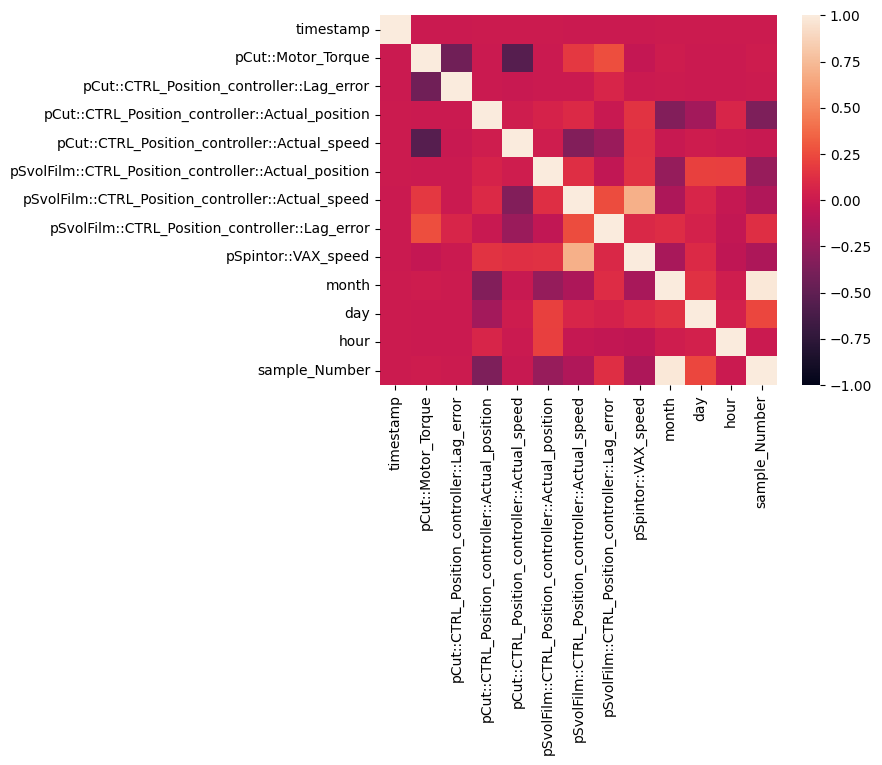

In [4]:
#heatmap of correlations from -1 to 1
sns.heatmap(main_df.corr(), vmin= -1, vmax = 1)


**为了获取更加直观清晰的理解，我们删除了一些列并翻转了电机转矩（×-1）**

<AxesSubplot:>

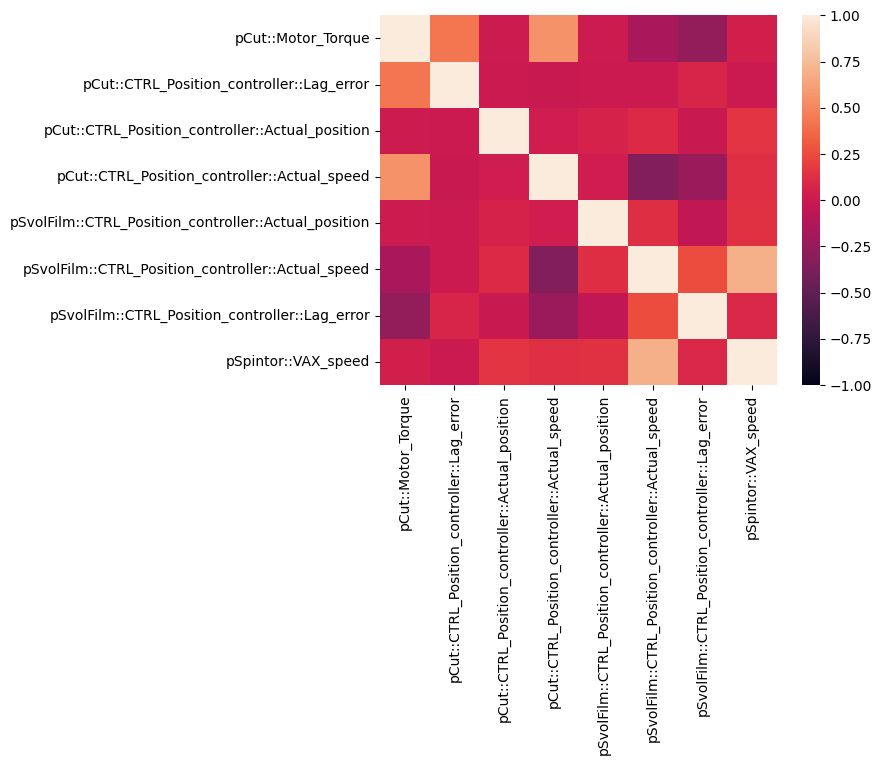

In [88]:
main_df = pd.read_csv('compiled_df//One_year_compiled.csv')
#Dropping nonsense columns for this proposal                                 (axis=1) = columns
main_df = main_df.drop(['day', 'hour', 'sample_Number', 'month', 'timestamp'], axis=1)
#Flipping column values
main_df['pCut::Motor_Torque'] = main_df['pCut::Motor_Torque'] *-1
sns.heatmap(main_df.corr(), vmin= -1, vmax = 1)


## 处理非数值型数据

**在我们的数据集中，机器的模式可能会影响数据模式，因此我们需要将数据从字符串转换为数值类。** 

In [8]:
def handle_non_numeric(df):
    columns = df.columns.values
    
    for column in columns:
        
        # Dictionary with each numerical value for each text
        text_digit_vals = {}
        
        def convert_to_int (val):
            return text_digit_vals[val]
        
        if df[column].dtype !=np.int64 and df[column].dtype != np.float64:
            
            column_contents = df[column].values.tolist()
            
            unique_elements = set(column_contents)
            
            x=0
            
            for unique in unique_elements:
                
                # Adds the class value for the text in dictionary, if it's not there
                if unique not in text_digit_vals:
                    text_digit_vals[unique] = x
                    x+=1
            
            df[column] = list(map(convert_to_int, df[column]))
    
    return df

# 方法

**我们主要采用了3种算法来进行测试并挖掘机器老化退化等的信息。单类SVM方法和单集群Kmeans方法主要将异常值和正常值进行聚类区分，自编码器方法则通过学习数据信息对健康工作状态的机器情况进行重构。**
**在所有3种情况下，我们将获取第一行的一个片段，并将其视为机器的健康状态，然后将其提供给算法。之后，我们将提供算法的整个数据集，并看看他们如何执行其余的数据。偏差、低增益和高损失将被认为是需要研究的异常。**

# 单类SVM方法

**单类SVM 用于异常检测，它试图在数据中找到2个类，即正常值和异常值。**

In [46]:
main_df = pd.read_csv('compiled_df//One_year_compiled.csv')
#Dropping columns with unwanted/irrelevant info for the algorithm
main_df = main_df.drop(['day', 'hour', 'sample_Number', 'month', 'timestamp'], axis=1)
main_df = handle_non_numeric(main_df)

X = main_df

#Defining preprocessor for the data
scaler = preprocessing.MinMaxScaler()
#Preprocessing
X = pd.DataFrame(scaler.fit_transform(X), 
                              columns=X.columns, 
                              index=X.index)


X = preprocessing.scale(X)
X_train = X[:200000]


#Creating a fitting OneClass SVM
ocsvm = OneClassSVM(nu=0.25, gamma=0.05)
ocsvm.fit(X_train)

OneClassSVM(gamma=0.05, nu=0.25)

**预测并分类异常和非异常的数据集，然后把它传递到一个dataframe。**

In [47]:


df=main_df.copy()
df['anomaly'] = pd.Series(ocsvm.predict(X))



**保存数据帧**

In [48]:
df.to_csv('compiled_df//Labled_df.csv')

**读取数据帧**

In [49]:
df = pd.read_csv('compiled_df//Labled_df.csv', index_col=0)
df.head()

pCut::Motor_Torque  pCut::CTRL_Position_controller::Lag_error  \
0            0.199603                                   0.027420   
1            0.281624                                   0.002502   
2            0.349315                                  -0.018085   
3            0.444450                                  -0.054680   
4            0.480923                                  -0.042770   

   pCut::CTRL_Position_controller::Actual_position  \
0                                        628392628   
1                                        628392625   
2                                        628392621   
3                                        628392617   
4                                        628392613   

   pCut::CTRL_Position_controller::Actual_speed  \
0                                   -920.104980   
1                                   -937.271118   
2                                   -951.004028   
3                                  -1019.668579   
4                                  -1023.101807   

   pSvolFilm::CTRL_Position_controller::Actual_position  \
0                                            5298555      
1                                            5298565      
2                                            5298575      
3                                            5298585      
4                                            5298595      

   pSvolFilm::CTRL_Position_controller::Actual_speed  \
0                                        2441.235352   
1                                        2453.819092   
2                                        2476.469727   
3                                        2501.637207   
4                                        2519.254395   

   pSvolFilm::CTRL_Position_controller::Lag_error  pSpintor::VAX_speed  mode  \
0                                        0.899543          1379.999756     6   
1                                        0.874072          1379.999756     6   
2                                        0.879806          1379.999756     6   
3                                        0.837500          1379.999756     6   
4                                        0.905347          1379.999756     6   

   anomaly  
0        1  
1        1  
2        1  
3        1  
4        1

**可视化异常值**

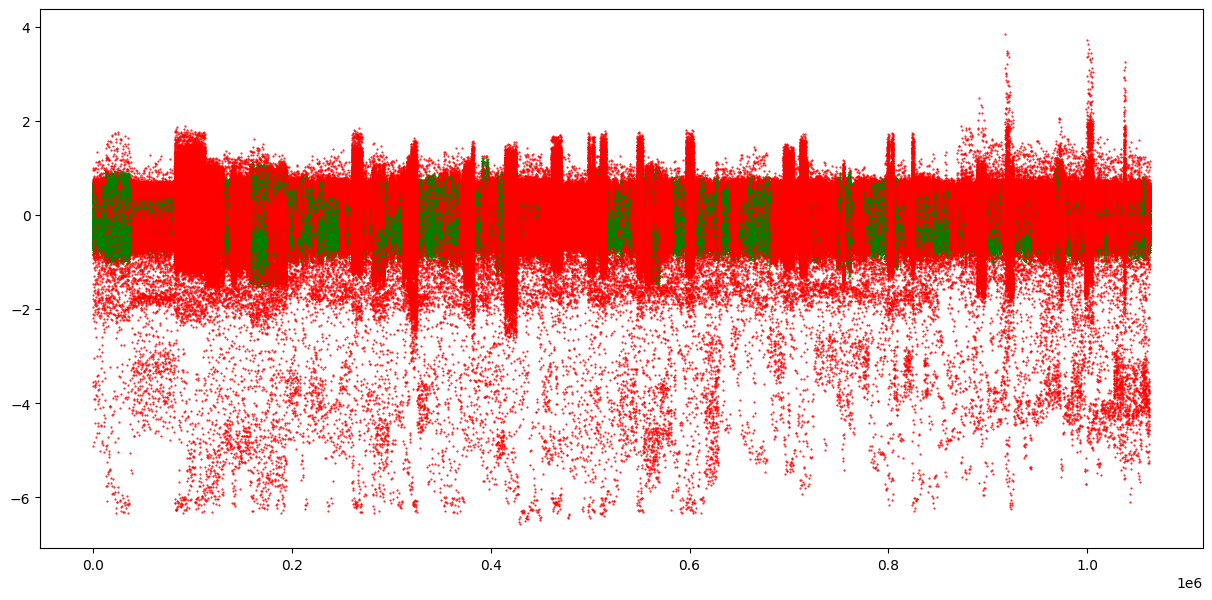

In [50]:
scat_1 = df.groupby('anomaly').get_group(1)
scat_0 = df.groupby('anomaly').get_group(-1)

plt.subplots(figsize=(15,7))
plt.plot(scat_1.index, scat_1['pCut::Motor_Torque'], 'g.', markersize=1)
plt.plot(scat_0.index, scat_0['pCut::Motor_Torque'],'r.', markersize=1)


散点图分为两类点：

- **绿色的点**代表正常的操作数据（标记为1的点）。
- **红色的点**代表异常的操作数据（标记为-1的点）。


1. **正常数据（绿色点）**：
   - 绿色的点集中在图的中间位置（大约在扭矩为-1到1的范围内），表明大部分正常数据的电机扭矩值较为稳定，没有明显的异常波动。
   - 这些点之间比较密集，说明在正常情况下，切割电机的扭矩变化较小，机器的运行状态是比较平稳的。

2. **异常数据（红色点）**：
   - 红色点分布更广，尤其是下方（-4至-6之间），这些数据显然偏离了正常数据的分布范围，表明这些时刻的电机扭矩发生了明显的异常波动。
   - 图中有几处非常集中的红点簇，这些区域可能代表在这些时间段内，机器运行出现了较大的问题或故障。
   - 在一些时间段，异常数据（红色）与正常数据（绿色）交叠，这表明在这些时刻机器的状态可能处于异常的边缘，虽然大多数数据是正常的，但也有一些数据点被标记为异常。



**可视化整个数据集的得分情况**

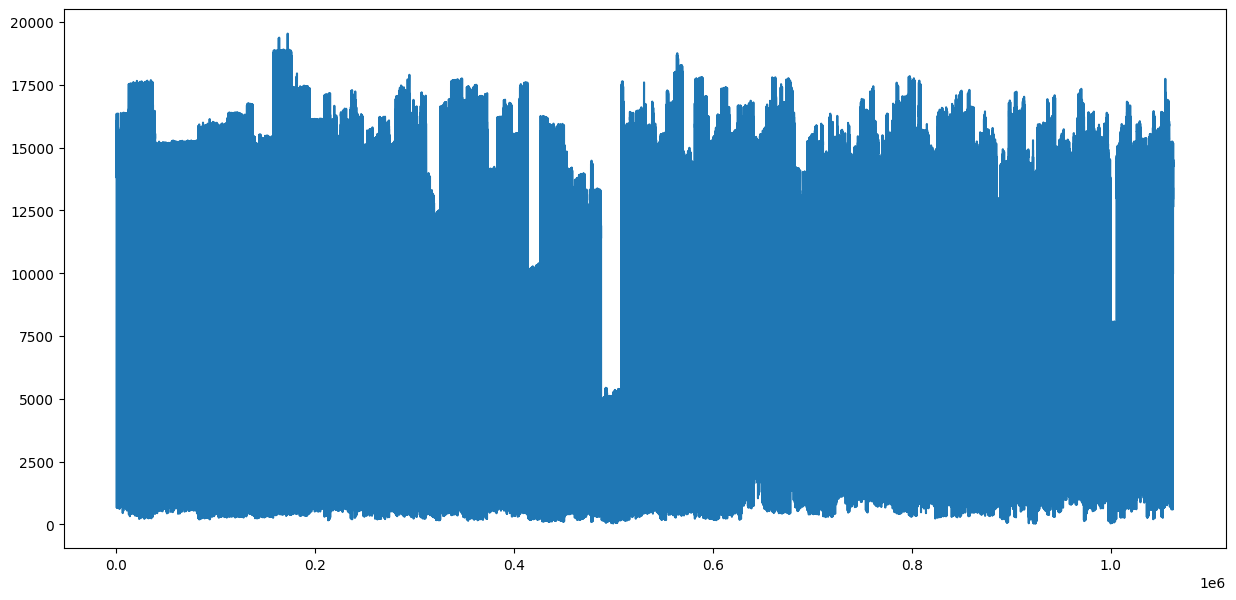

In [51]:
#Creating a dataframe for the score of each data sample
score = pd.DataFrame()
score['score'] = ocsvm.score_samples(X)

plt.subplots(figsize=(15,7))
#Plotting
score['score'].plot()
score.to_csv('compiled_df//SVM_Score.csv')


**对上述得分乘以-1**

<AxesSubplot:>

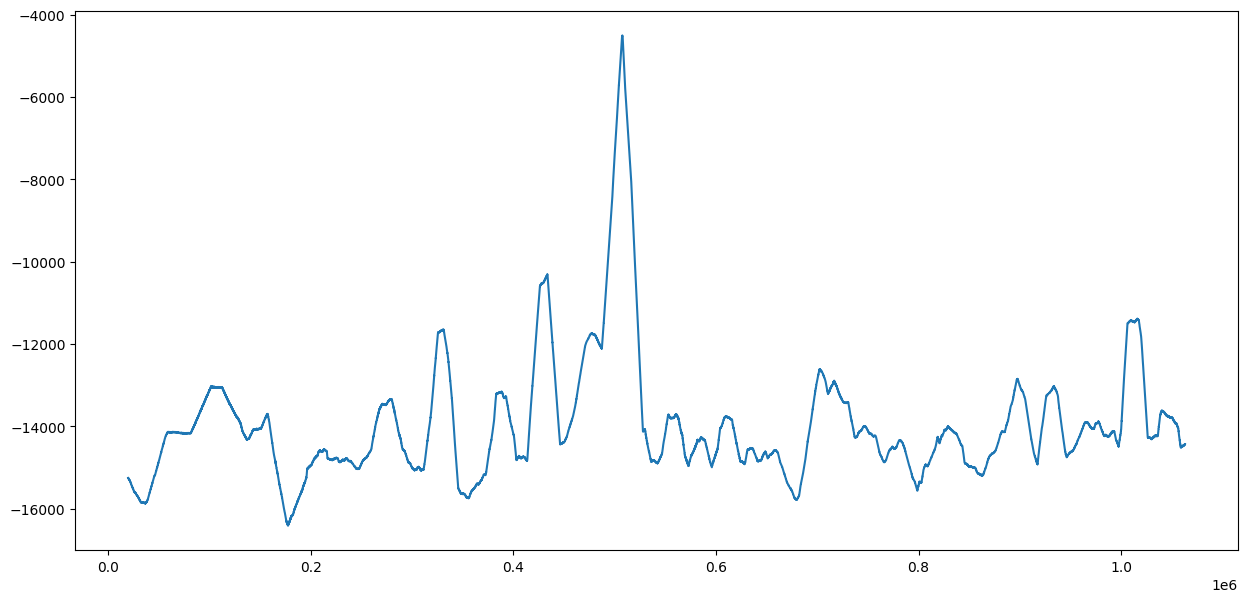

In [52]:
fig, ax = plt.subplots(figsize=(15,7))


((score['score'].rolling(20000).mean())*-1).plot(ax=ax)


**绘制散点图并观察分数**

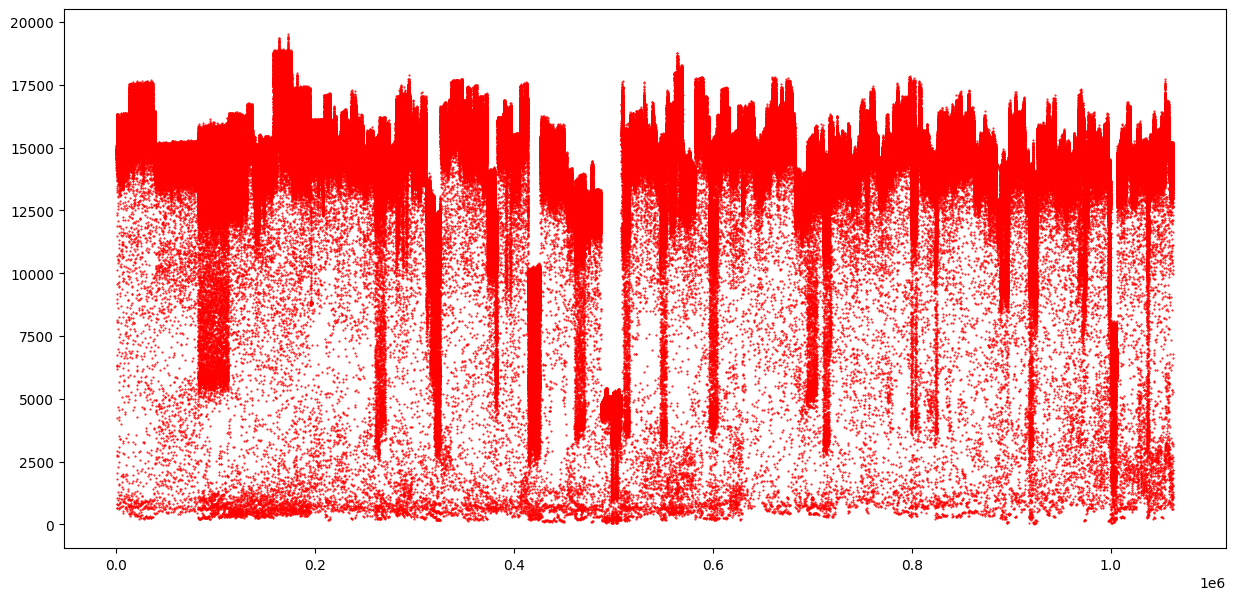

In [53]:
plt.subplots(figsize=(15,7))
plt.plot(score.index, score['score'],'r.', markersize=1)

# KMeans 方法

**Kmeans 方法和单类SVM所做的基本类似**

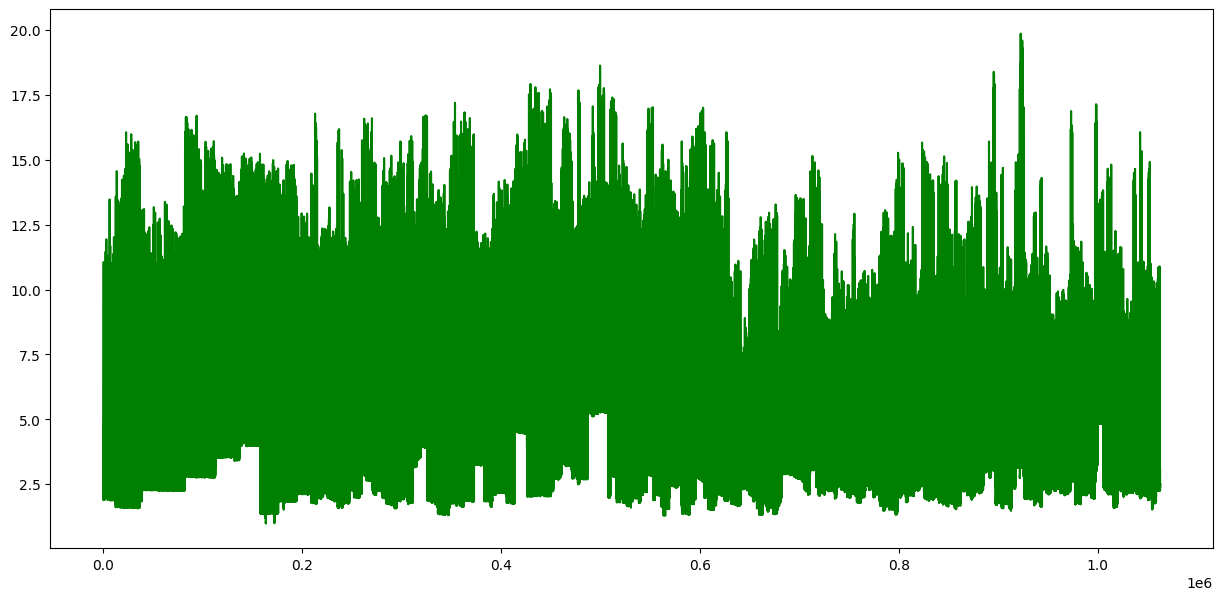

In [91]:
#------ Preparing features for training and future prediction -----
main_df = pd.read_csv('compiled_df//One_year_compiled.csv')
main_df = main_df.drop(['day', 'hour', 'sample_Number', 'month', 'timestamp'], axis=1)
main_df = handle_non_numeric(main_df)
X = main_df

scaler = preprocessing.MinMaxScaler()

X = pd.DataFrame(scaler.fit_transform(X), 
                              columns=X.columns, 
                              index=X.index)



X = preprocessing.scale(X)
#-------------------------------------------------------------------


#Percentage of the data that will be considered healthy condition
train_percentage = 0.15
train_size = int(len(main_df.index)*train_percentage)
X_train = X[:train_size]


#Defining KMeans with 1 cluster
kmeans = KMeans(n_clusters=1)
kmeans.fit(X_train)

#Creating a copy of the main dataset
k_anomaly = main_df.copy()

k_anomaly = pd.DataFrame(kmeans.transform(X))

k_anomaly.to_csv('compiled_df//KM_Distance.csv')

plt.subplots(figsize=(15,7))
plt.plot(k_anomaly.index, k_anomaly[0], 'g', markersize=1)

# 自编码器方法



**自编码器类的神经网络会通过扩展或压缩数据到更高或更低的维度来学习如何重建数据。其关键想法是自编码器会理解特征之间的相关性，并以此为基础重建尽可能准确的数据。**



**我们会将机器的健康状态送入算法中。然后因为自编码器会尝试重建剩余数据的健康状态，预测的机器数据和实际的机器数据会通过重构损失显示两者之间的差异，近而可以判定哪些是“不健康”的状态。**

In [55]:
#------------------------- Preparing data for training --------------------------- 
main_df = pd.read_csv('compiled_df//One_year_compiled.csv')
main_df = main_df.drop(['day', 'hour', 'sample_Number', 'month', 'timestamp'], axis=1)
main_df = handle_non_numeric(main_df)
X = main_df

scaler = preprocessing.MinMaxScaler()

X = pd.DataFrame(scaler.fit_transform(X), 
                              columns=X.columns, 
                              index=X.index)



X = preprocessing.scale(X)


train_percentage = 0.15
train_size = int(len(main_df.index)*train_percentage)

X_train = X[:train_size]
#----------------------------------------------------------------------------------



#Seed for random batch validation and training
seed(10)
set_random_seed(10)

act_func = 'elu'
model=Sequential()
model.add(Dense(50,activation=act_func,
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_shape=(X_train.shape[1],)
               )
         )

model.add(Dense(10,activation=act_func,
                kernel_initializer='glorot_uniform'))
model.add(Dense(50,activation=act_func,
                kernel_initializer='glorot_uniform'))
model.add(Dense(X_train.shape[1],
                kernel_initializer='glorot_uniform'))
model.compile(loss='mse',optimizer='adam')

NUM_EPOCHS=50
BATCH_SIZE=200

#Grabbing validation and training loss over epochs
history=model.fit(np.array(X_train),np.array(X_train),
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.1,
                  verbose = 1)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Train on 143492 samples, validate on 15944 samples
Epoch 1/50


2024-10-19 07:27:07.129359: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-10-19 07:27:07.299384: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA A100 80GB PCIe major: 8 minor: 0 memoryClockRate(GHz): 1.41
pciBusID: 0000:1a:00.0
2024-10-19 07:27:07.300641: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 1 with properties: 
name: NVIDIA A100 80GB PCIe major: 8 minor: 0 memoryClockRate(GHz): 1.41
pciBusID: 0000:1b:00.0
2024-10-19 07:27:07.301950: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 2 with properties: 
name: NVIDIA A100 80GB PCIe major: 8 minor: 0 memoryClockRate(GHz): 1.41
pciBusID: 0000:3d:00.0
2024-10-19 07:27:07.303209: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 3 with properties: 
name: NVIDIA A100 80GB PCIe major: 8 minor: 0 memoryClockRate(GHz): 1.41
pciBusID: 0000:3e:00.0
202

   200/143492 [..............................] - ETA: 20:11 - loss: 1.4272

2024-10-19 07:27:08.639453: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x56461afab4c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-19 07:27:08.639488: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-10-19 07:27:08.639496: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-10-19 07:27:08.639501: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-10-19 07:27:08.639507: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (3): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-10-19 07:27:08.639512: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (4): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-10-19 07:27:08.639518: I tensorflow/c

143492/143492 [==============================] - 3s 22us/sample - loss: 0.0823 - val_loss: 0.0105
Epoch 2/50
143492/143492 [==============================] - 1s 10us/sample - loss: 0.0023 - val_loss: 0.0046
Epoch 3/50
143492/143492 [==============================] - 1s 10us/sample - loss: 9.5011e-04 - val_loss: 0.0035
Epoch 4/50
143492/143492 [==============================] - 1s 10us/sample - loss: 5.5827e-04 - val_loss: 0.0024
Epoch 5/50
143492/143492 [==============================] - 2s 11us/sample - loss: 3.7272e-04 - val_loss: 0.0024
Epoch 6/50
143492/143492 [==============================] - 2s 11us/sample - loss: 2.6266e-04 - val_loss: 0.0019
Epoch 7/50
143492/143492 [==============================] - 2s 10us/sample - loss: 2.1032e-04 - val_loss: 0.0016
Epoch 8/50
143492/143492 [==============================] - 2s 10us/sample - loss: 1.6458e-04 - val_loss: 0.0015
Epoch 9/50
143492/143492 [==============================] - 1s 10us/sample - loss: 1.4004e-04 - val_loss: 0.0015
Ep

**绘制各个 epoch 的验证损失和训练损失**

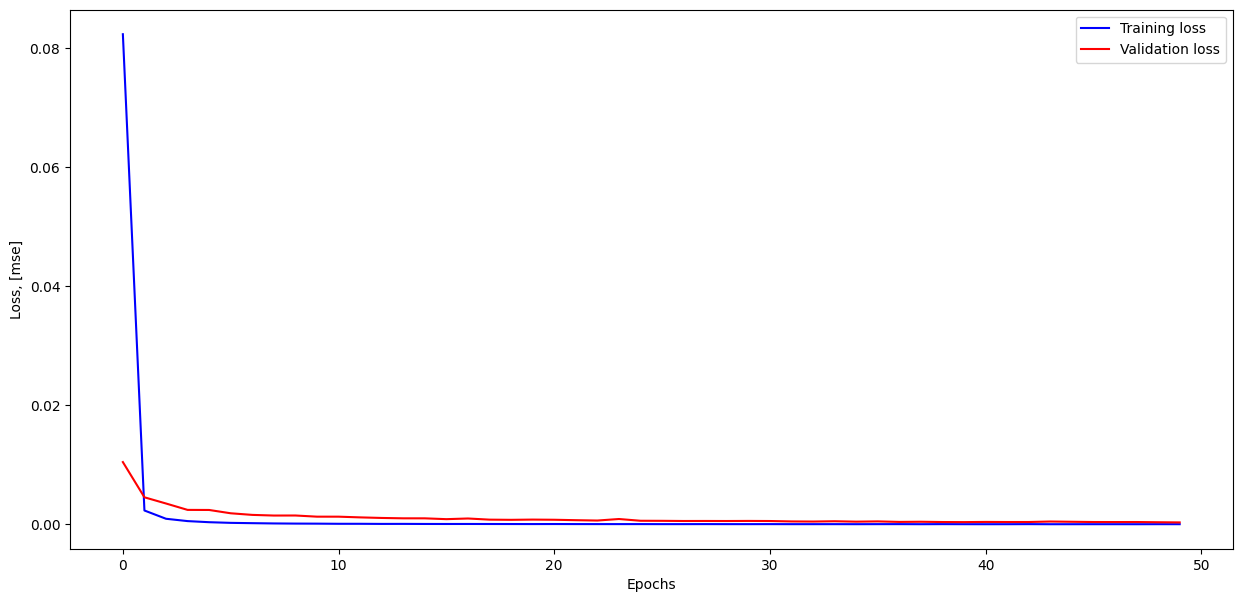

In [56]:
plt.subplots(figsize=(15,7))

plt.plot(history.history['loss'],'b',label='Training loss')
plt.plot(history.history['val_loss'],'r',label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')

plt.show()


**现在我们将把同样的训练数据送入算法中，并让它尝试去重构数据。我们能得到训练数据的损失分布，随后我们会用这个分布决定一个判定机器是否健康的阈值。**

/root/anaconda3/envs/Big-Data/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



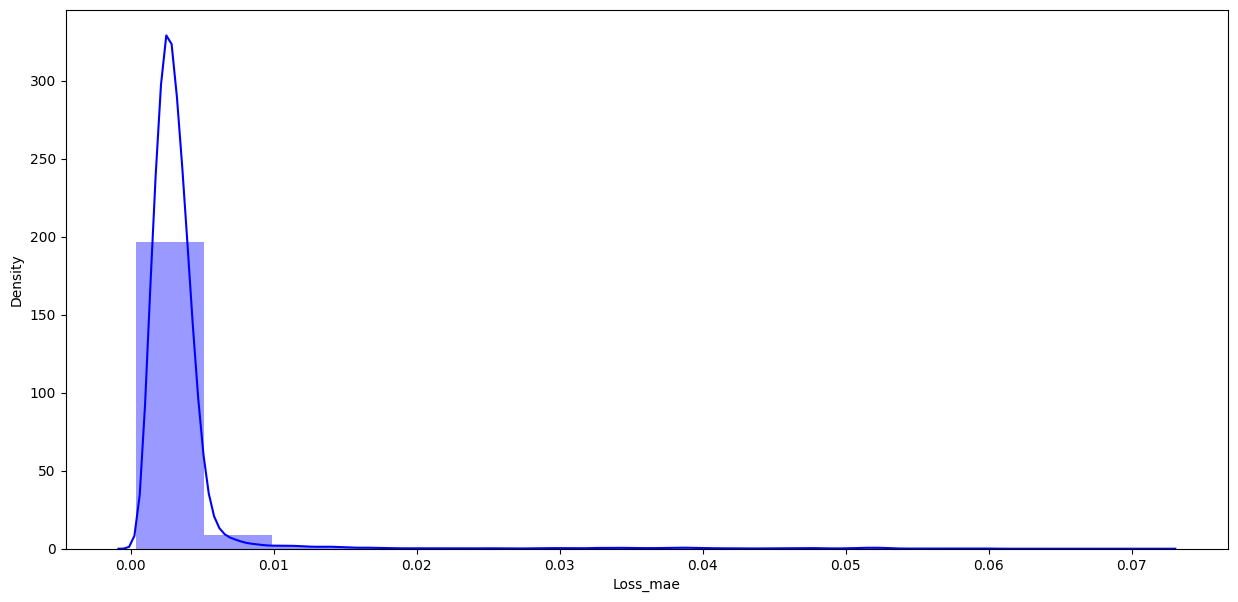

In [57]:
#Reconstructing train data
X_pred = model.predict(np.array(X_train))

#Creating dataframe for reconstructed data
X_pred = pd.DataFrame(X_pred,columns=main_df.columns)
X_pred.index = pd.DataFrame(X_train).index

#Dataframe to get the difference of predicted data and real data. 
scored = pd.DataFrame(index=pd.DataFrame(X_train).index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_train), axis = 1)

plt.subplots(figsize=(15,7))
sns.distplot(scored['Loss_mae'],
             bins = 15, 
             kde= True,
            color = 'blue');






**重复上述操作，不过这次是把所有数据送入算法，最后得到了一些有趣的数据。**

Text(0, 0.5, 'Loss, [mse]')

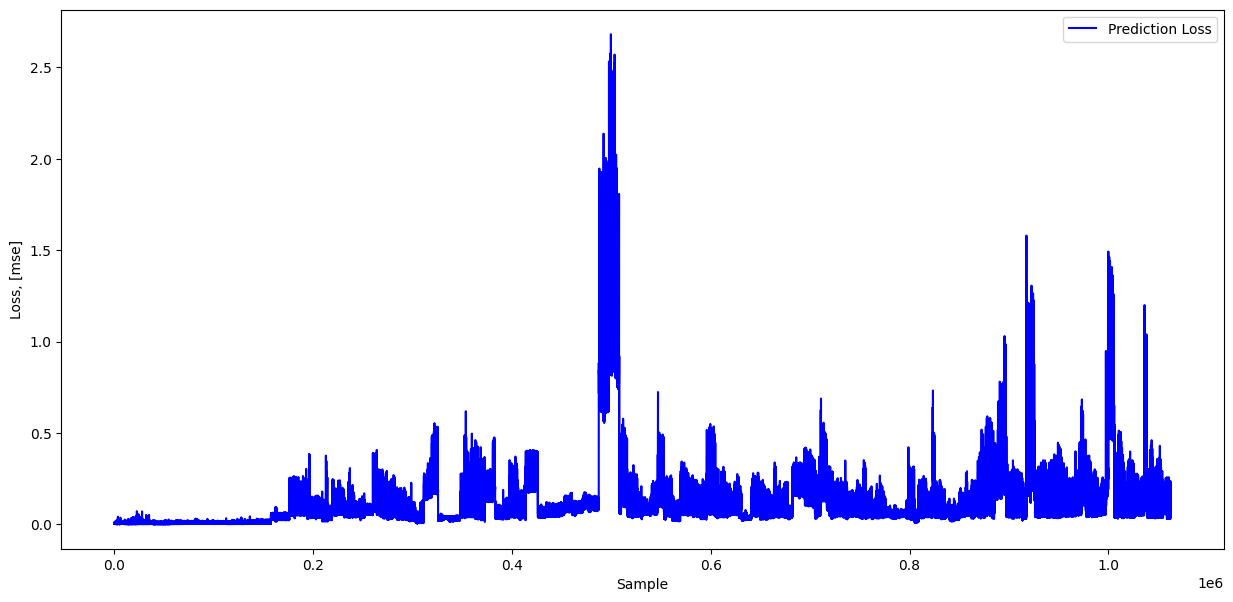

In [58]:

#Reconstructing full data
X_pred = model.predict(np.array(X))
X_pred = pd.DataFrame(X_pred,columns=main_df.columns)
X_pred.index = pd.DataFrame(X).index

#Returning mean of the losses for each column and putting it in a dataframe
scored = pd.DataFrame(index=pd.DataFrame(X).index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X), axis = 1)

plt.subplots(figsize=(15,7))


#Saving dataframe
scored.to_csv('compiled_df//AutoEncoder_loss.csv')

plt.plot(scored['Loss_mae'],'b',label='Prediction Loss')

plt.legend(loc='upper right')
plt.xlabel('Sample')
plt.ylabel('Loss, [mse]')

# 结果分析

 **每个方法一张散点图**

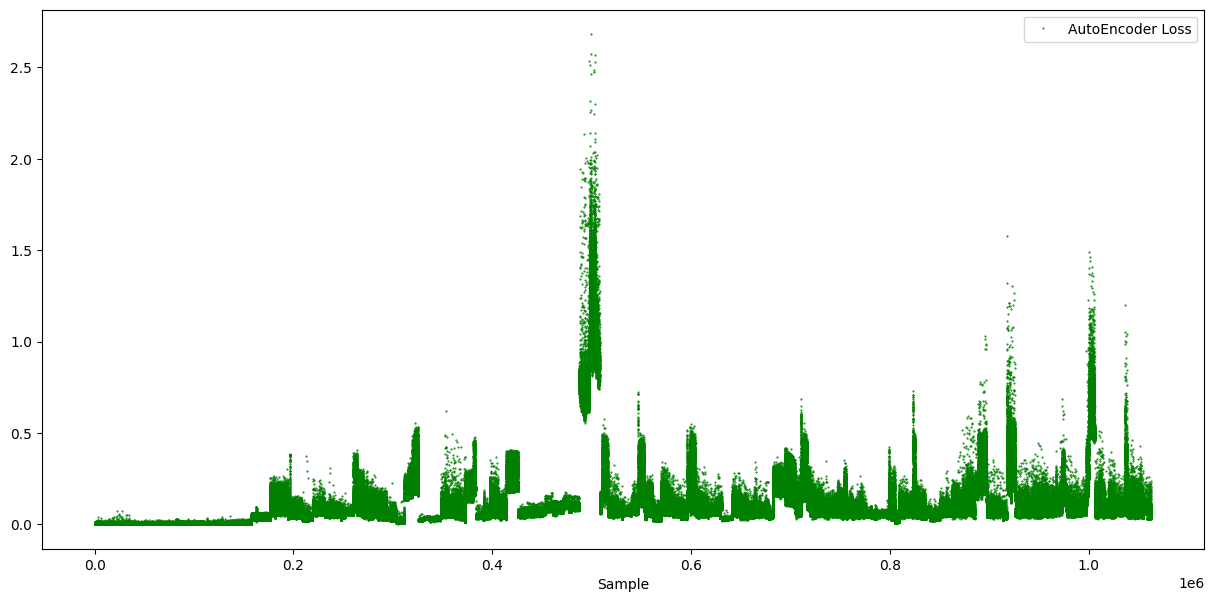

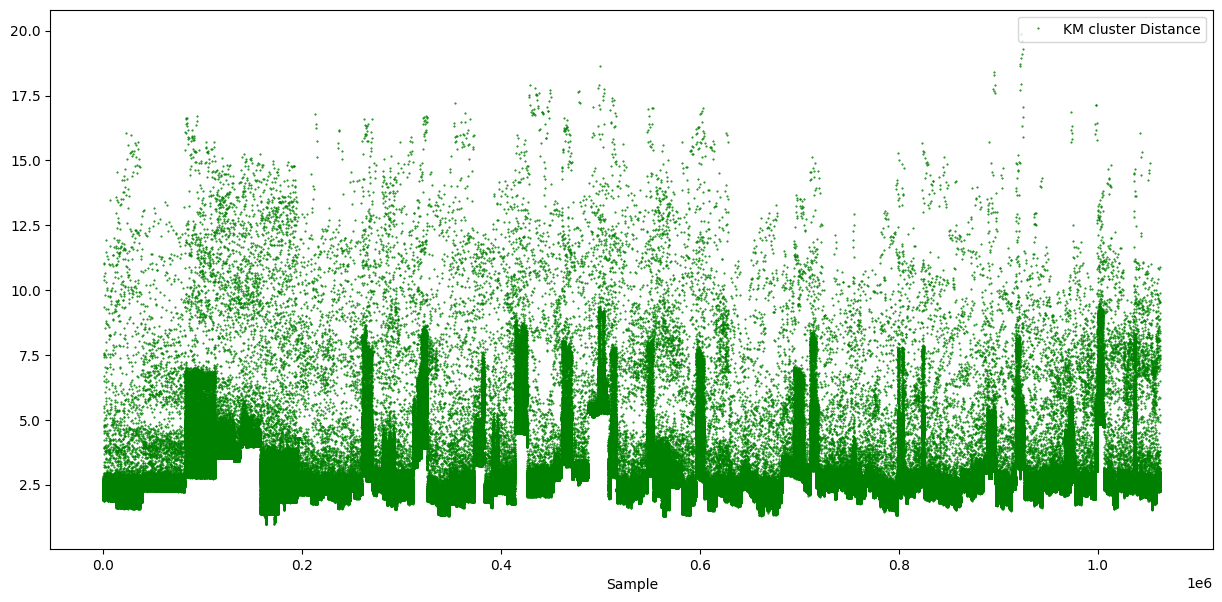

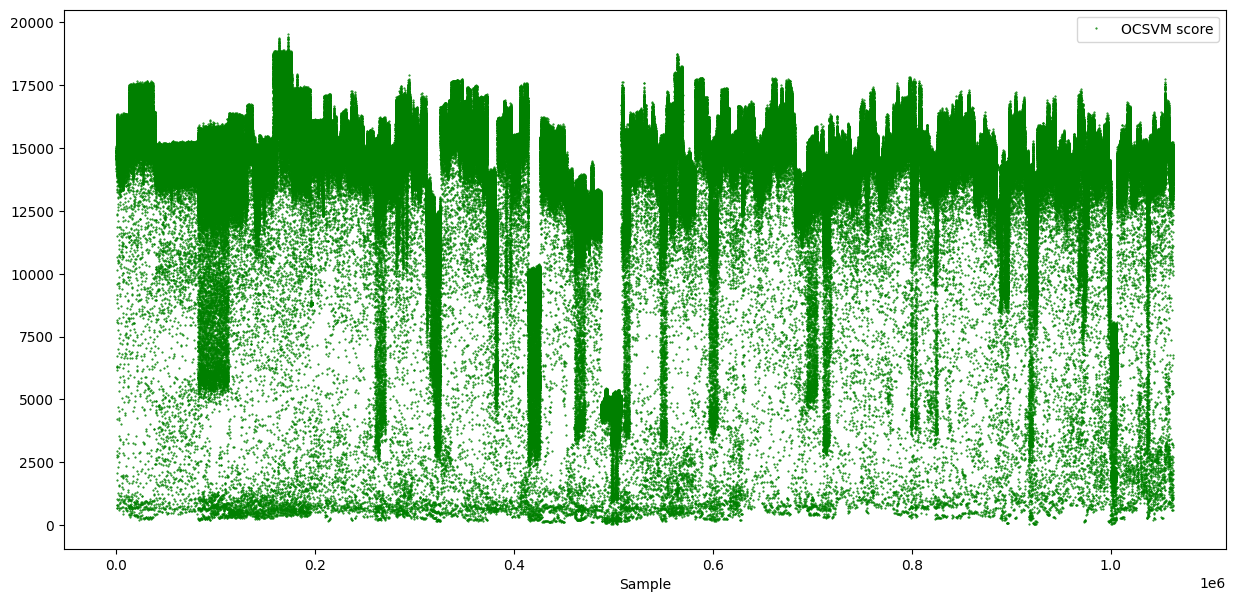

In [5]:
plt.subplots(figsize=(15,7))
#Reading loss csv file
enc_loss = pd.read_csv('compiled_df//AutoEncoder_loss.csv')
plt.plot(enc_loss.index,enc_loss['Loss_mae'], 'g.', markersize=1,label="AutoEncoder Loss")
plt.legend(loc='upper right')
plt.xlabel('Sample')
plt.show()

plt.subplots(figsize=(15,7))
k_anomaly = pd.read_csv('compiled_df//KM_Distance.csv')
plt.plot(k_anomaly.index,k_anomaly['0'], 'g.', markersize=1,label="KM cluster Distance")
plt.legend(loc='upper right')
plt.xlabel('Sample')
plt.show()

plt.subplots(figsize=(15,7))
score = pd.read_csv('compiled_df//SVM_Score.csv')
plt.plot(score.index,score['score'], 'g.', markersize=1,label="OCSVM score")
plt.legend(loc='upper right')
plt.xlabel('Sample')
plt.show()



**将三种方法所得结果呈现在一张图中（OCSVM的分数进行如下变换：除以最大值再乘-1）**

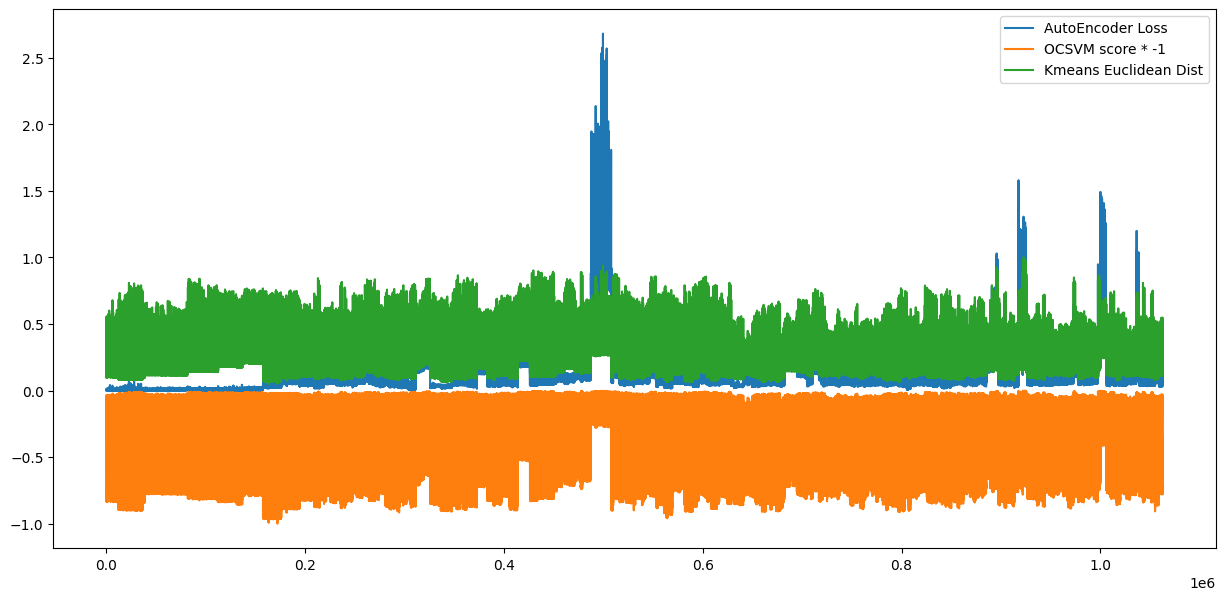

In [60]:
plt.subplots(figsize=(15,7))

k_anomaly = pd.read_csv('compiled_df//KM_Distance.csv')
score = pd.read_csv('compiled_df//SVM_Score.csv')
enc_loss = pd.read_csv('compiled_df//AutoEncoder_loss.csv')

#Scaling data for vizualization
k_distance = k_anomaly/k_anomaly.max()
svm_score = (score/score.max())*-1

plt.plot(enc_loss.index,enc_loss['Loss_mae'], label="AutoEncoder Loss")
plt.plot(svm_score.index, svm_score['score'],label="OCSVM score")
plt.plot(k_distance.index,k_distance['0'], label="Kmeans Euclidean Dist")



plt.gca().legend(('AutoEncoder Loss','OCSVM score * -1','Kmeans Euclidean Dist'))


**寻找算法之间的相关性**

<AxesSubplot:>

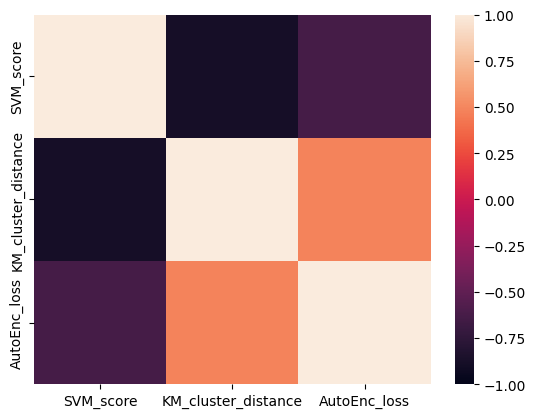

In [8]:
k_anomaly = pd.read_csv('compiled_df//KM_Distance.csv')
score = pd.read_csv('compiled_df//SVM_Score.csv')
enc_loss = pd.read_csv('compiled_df//AutoEncoder_loss.csv')

# Dataframe to see correlation
corr = pd.DataFrame()

#Passing score data to corr dataframe 
corr['SVM_score'] = score['score']
corr['KM_cluster_distance'] = k_anomaly['0']
corr['AutoEnc_loss'] = enc_loss['Loss_mae']

#Seeing correlation
corr.corr()
sns.heatmap(corr.corr(), vmin= -1, vmax = 1)

**使用移动平均绘制散点图**

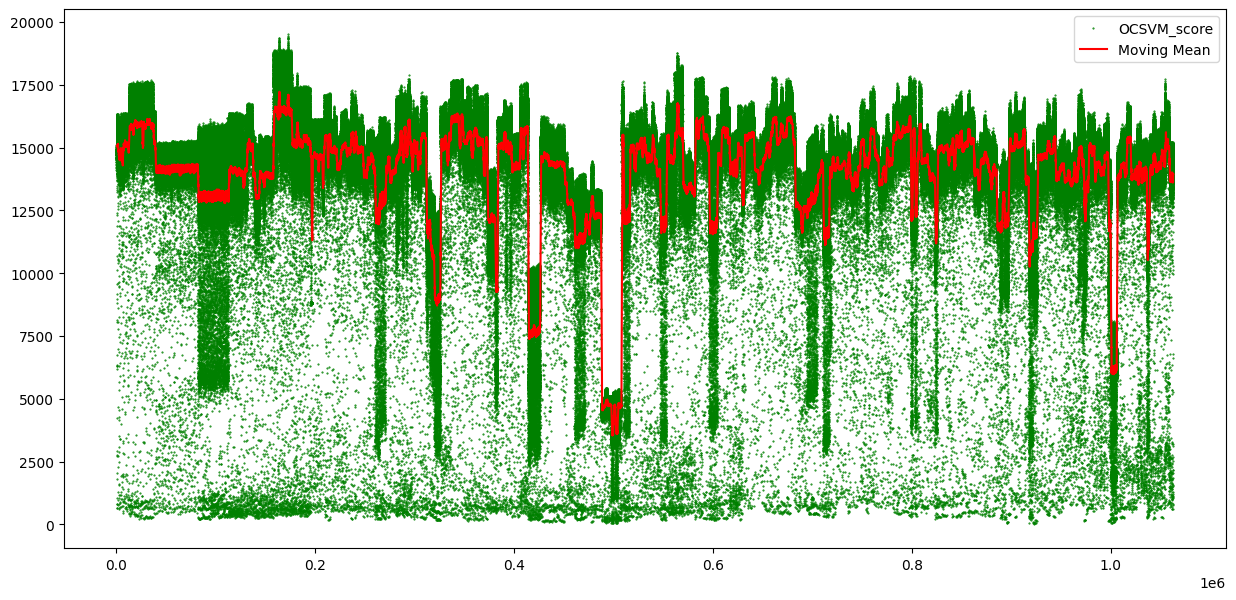

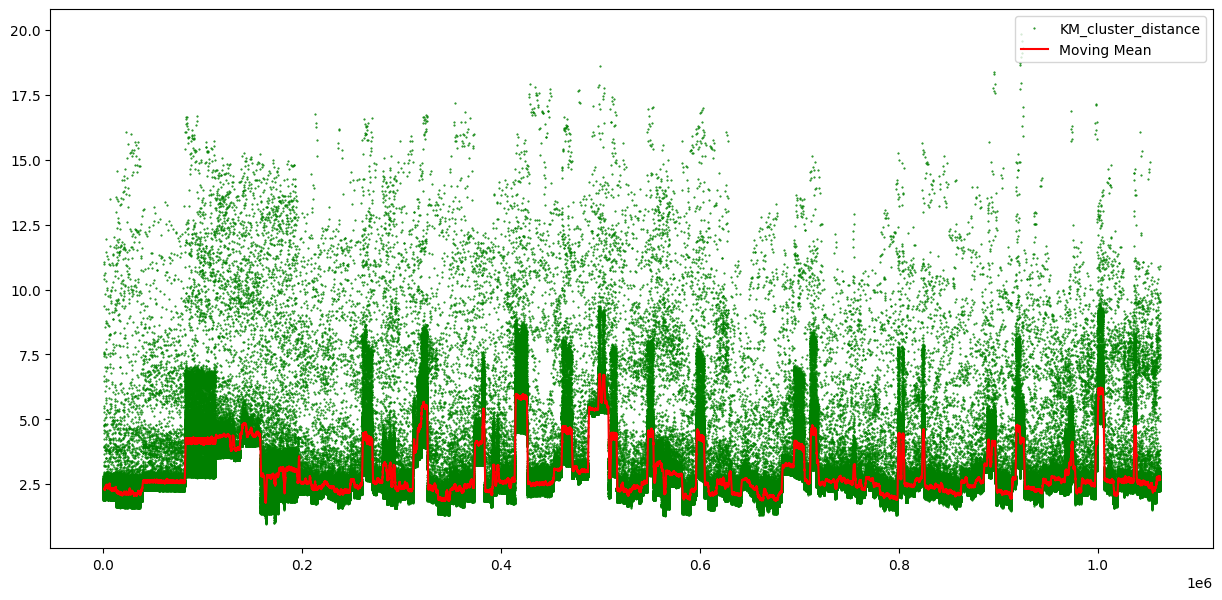

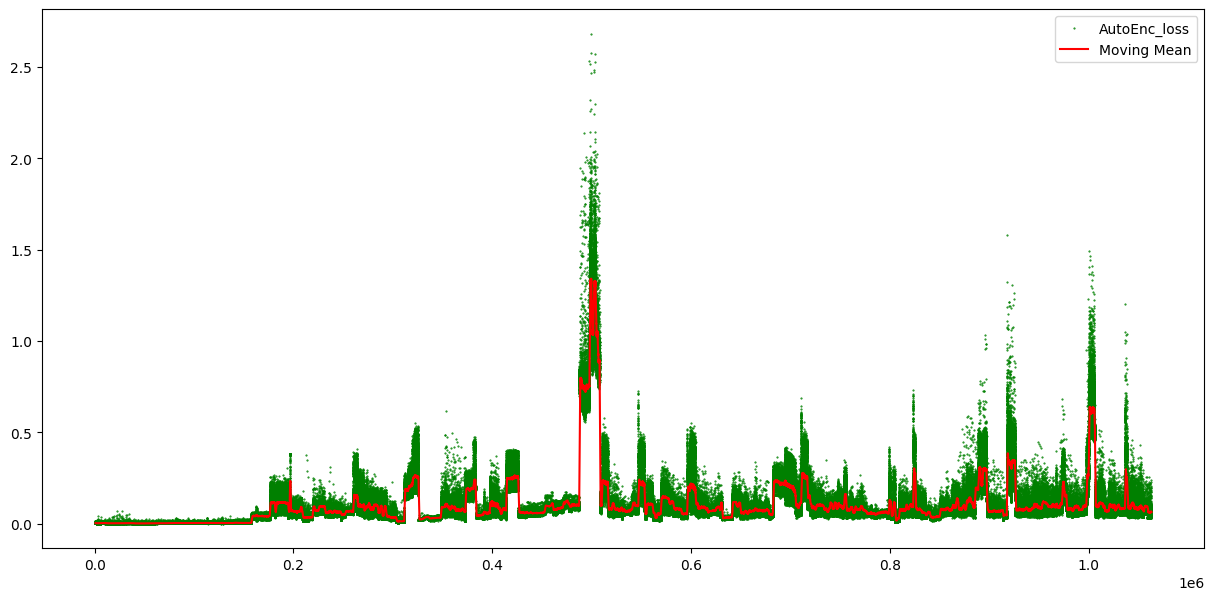

In [62]:
#---- Reading data and passing it to dataframe again ----- 

k_anomaly = pd.read_csv('compiled_df//KM_Distance.csv')
score = pd.read_csv('compiled_df//SVM_Score.csv')
enc_loss = pd.read_csv('compiled_df//AutoEncoder_loss.csv')

corr = pd.DataFrame()
corr['SVM_score'] = score['score']
corr['KM_cluster_distance'] = k_anomaly['0']
corr['AutoEnc_loss'] = enc_loss['Loss_mae']
#---------------------------------------------------------


#Plot size
plt.subplots(figsize=(15,7))

#Scatter plot of SVM score
plt.plot(corr.index, corr['SVM_score'], 'g.', markersize=1, label = 'OCSVM_score')
#Plotting moving mean of 1000 data points
plt.plot(corr.index, corr['SVM_score'].rolling(1000).mean(), 'r', markersize=1, label = 'Moving Mean')
#Legend
plt.legend(loc='upper right')
#Show
plt.show()


plt.subplots(figsize=(15,7))
  
plt.plot(corr.index, corr['KM_cluster_distance'], 'g.', markersize=1, label = 'KM_cluster_distance')
plt.plot(corr.index, corr['KM_cluster_distance'].rolling(1000).mean(), 'r', markersize=1, label = 'Moving Mean')

plt.legend(loc='upper right')
plt.show()





plt.subplots(figsize=(15,7))
  
plt.plot(corr.index, corr['AutoEnc_loss'], 'g.', markersize=1, label = 'AutoEnc_loss')
plt.plot(corr.index, corr['AutoEnc_loss'].rolling(1000).mean(), 'r', markersize=1, label = 'Moving Mean')


plt.legend(loc='upper right')
plt.show()



**训练数据的损失分布**

/root/anaconda3/envs/Big-Data/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  from ipykernel import kernelapp as app


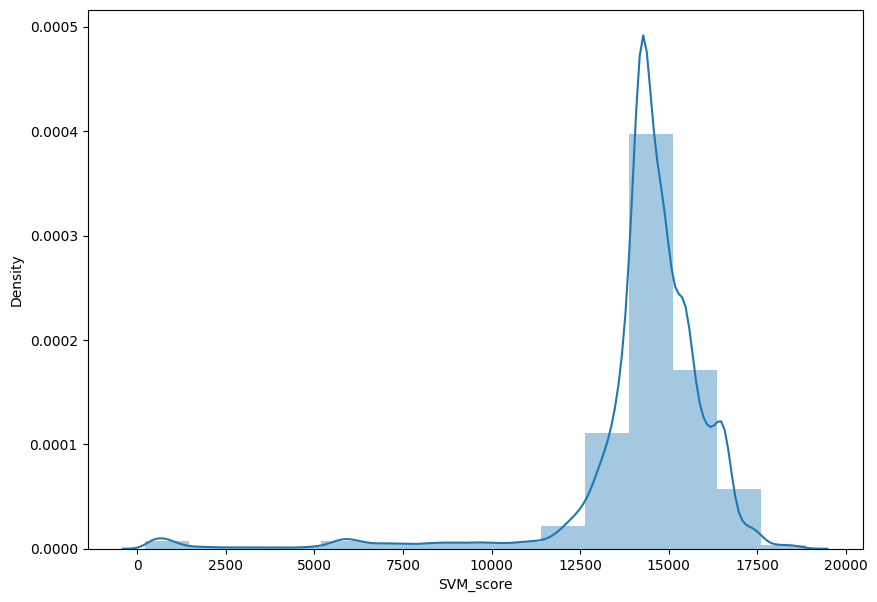

/root/anaconda3/envs/Big-Data/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



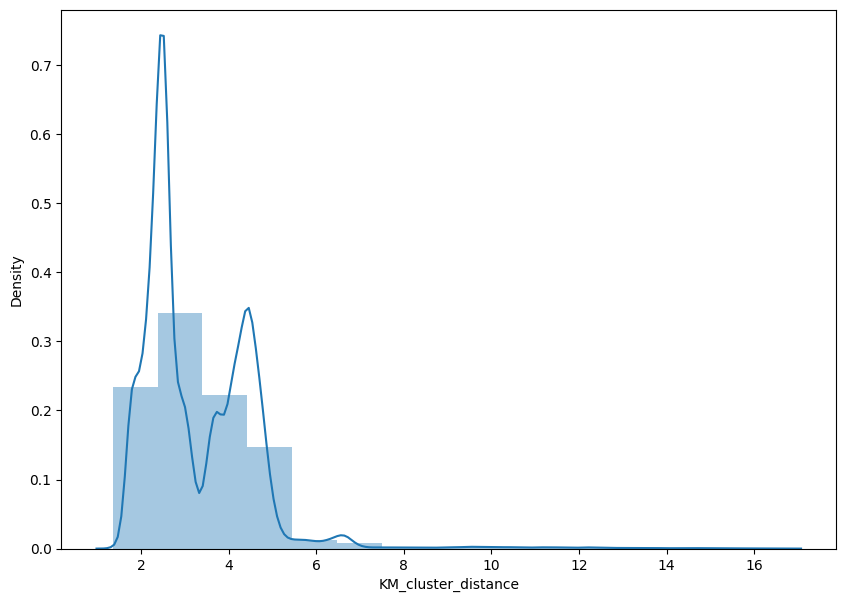

/root/anaconda3/envs/Big-Data/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



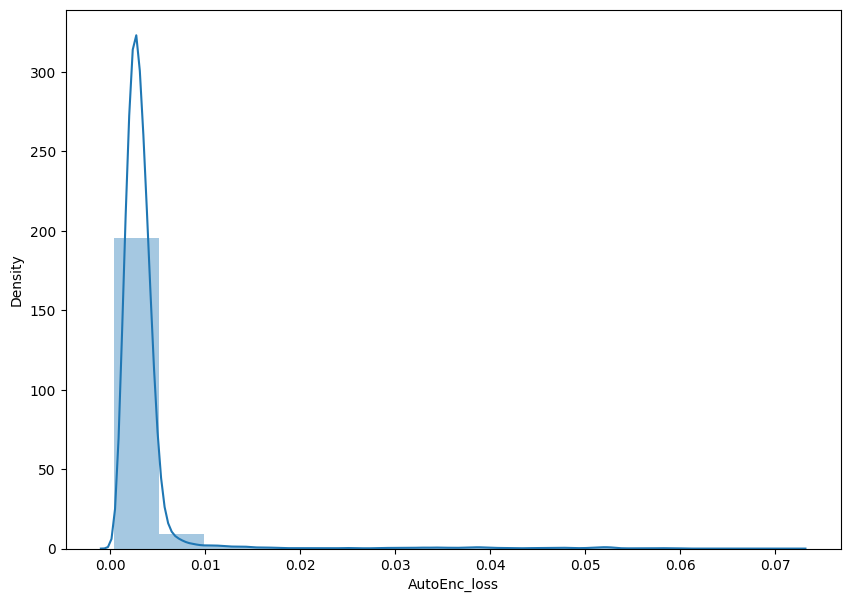

In [66]:
k_anomaly = pd.read_csv('compiled_df//KM_Distance.csv')
score = pd.read_csv('compiled_df//SVM_Score.csv')
enc_loss = pd.read_csv('compiled_df//AutoEncoder_loss.csv')

corr = pd.DataFrame()
corr['SVM_score'] = score['score']
corr['KM_cluster_distance'] = k_anomaly['0']
corr['AutoEnc_loss'] = enc_loss['Loss_mae']



#Plot size
plt.subplots(figsize=(10,7))
#Hist plot of first 160.000 rows, 15 bins
sns.distplot(corr['SVM_score'].head(160000), bins=15)
#Show
plt.show()

plt.subplots(figsize=(10,7))
sns.distplot(corr['KM_cluster_distance'].head(160000),bins=15)
plt.show()

plt.subplots(figsize=(10,7))
sns.distplot(corr['AutoEnc_loss'].head(160000),bins=15)
plt.show()

**整个数据集的损失分布**

/root/anaconda3/envs/Big-Data/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  from ipykernel import kernelapp as app


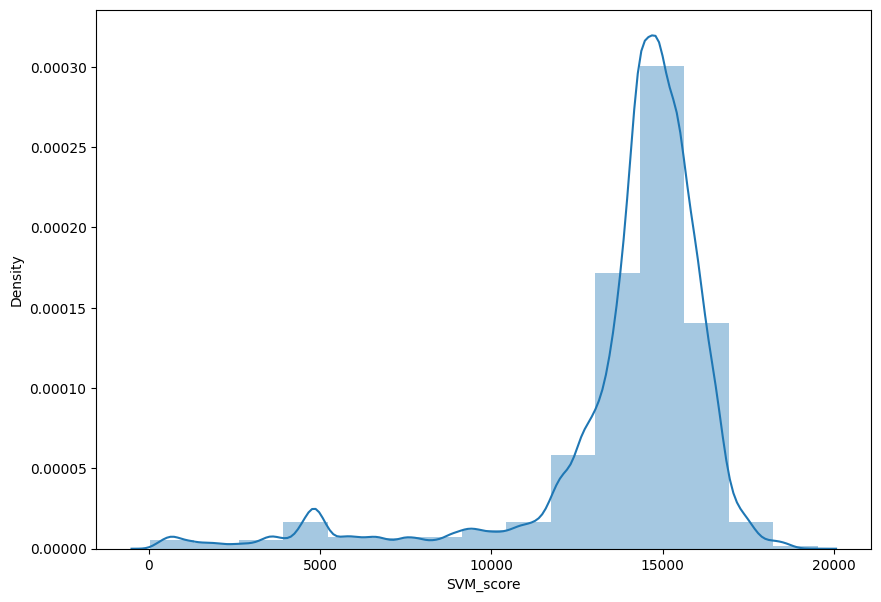

/root/anaconda3/envs/Big-Data/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



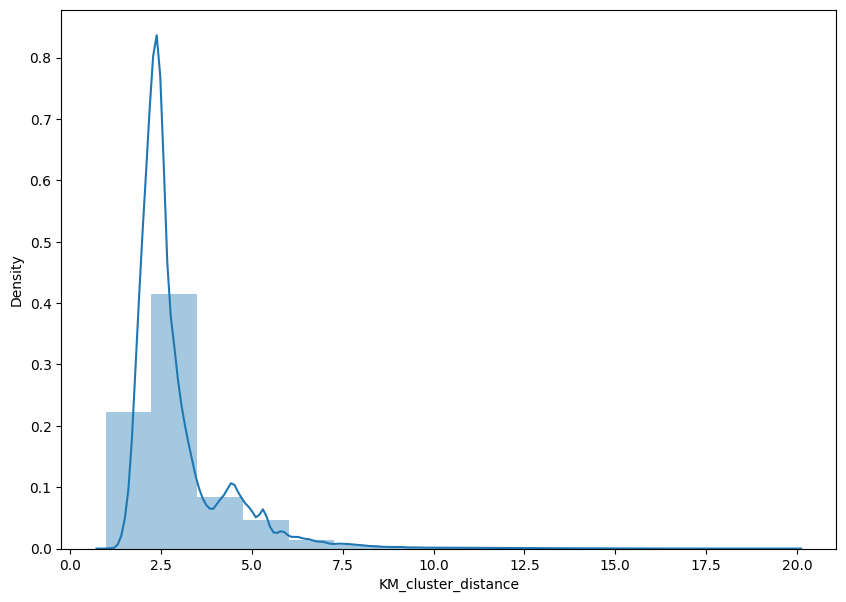

/root/anaconda3/envs/Big-Data/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



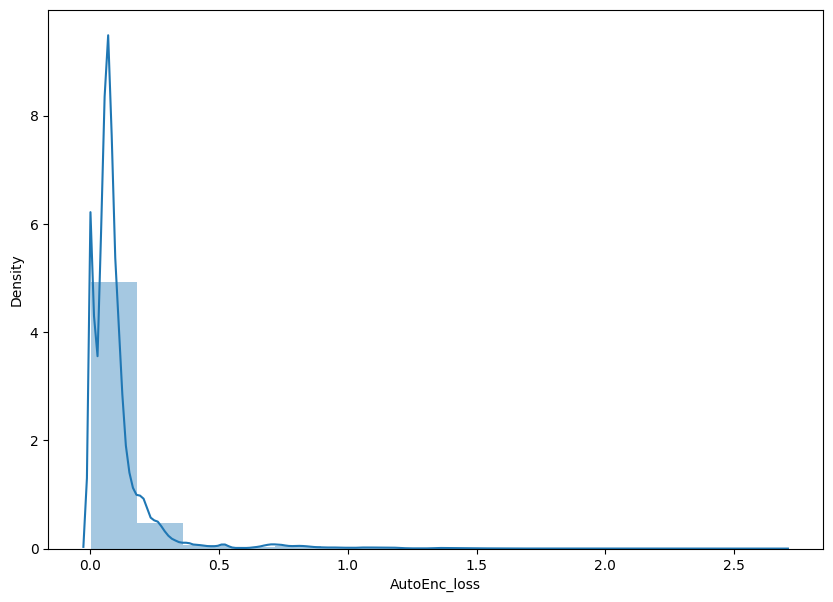

In [67]:
k_anomaly = pd.read_csv('compiled_df//KM_Distance.csv')
score = pd.read_csv('compiled_df//SVM_Score.csv')
enc_loss = pd.read_csv('compiled_df//AutoEncoder_loss.csv')

corr = pd.DataFrame()
corr['SVM_score'] = score['score']
corr['KM_cluster_distance'] = k_anomaly['0']
corr['AutoEnc_loss'] = enc_loss['Loss_mae']





plt.subplots(figsize=(10,7))
sns.distplot(corr['SVM_score'], bins=15)
plt.show()

plt.subplots(figsize=(10,7))
sns.distplot(corr['KM_cluster_distance'],bins=15)
plt.show()

plt.subplots(figsize=(10,7))
sns.distplot(corr['AutoEnc_loss'],bins=15)
plt.show()

**现在我们将使用训练损失分布的信息来确定图表的一些阈值同时绘制移动平均值。**

**_Upper threshold = 训练损失分布的最高值_**

**_Lower threshold = 训练损失分布的最小值_**

**_Highest density = 训练损失分布的模式_**

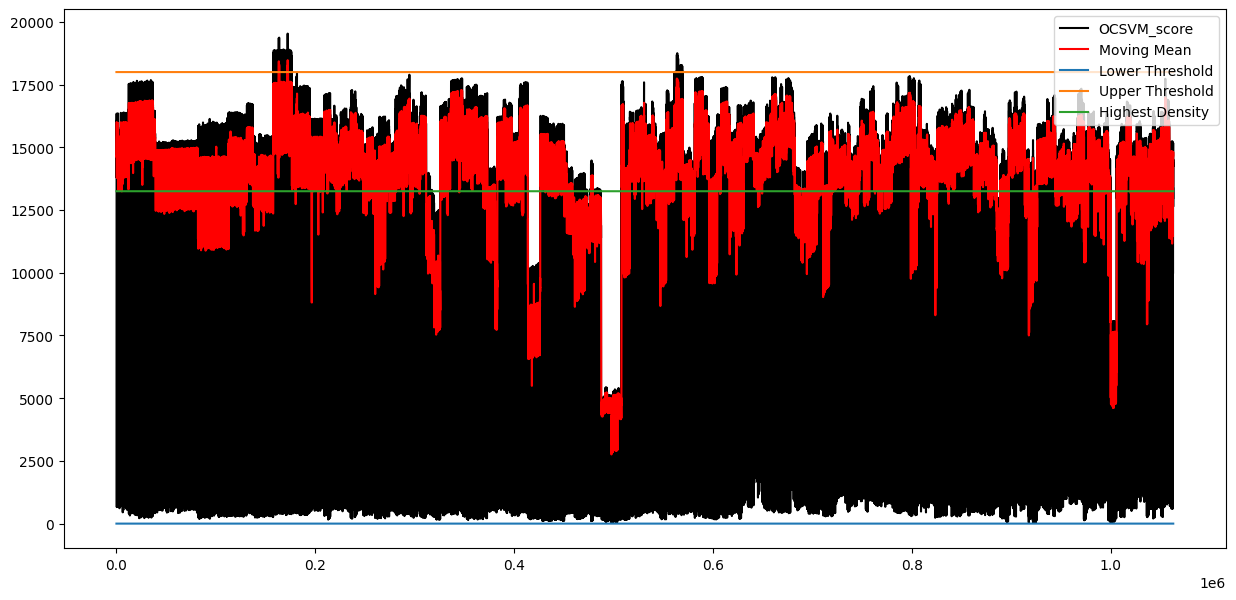

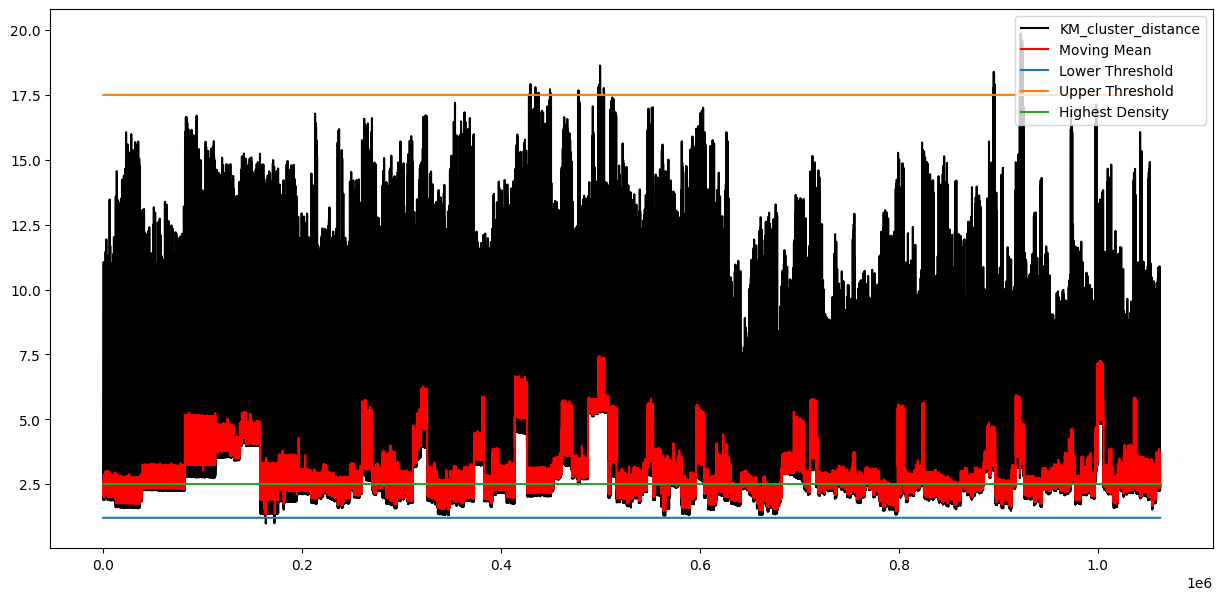

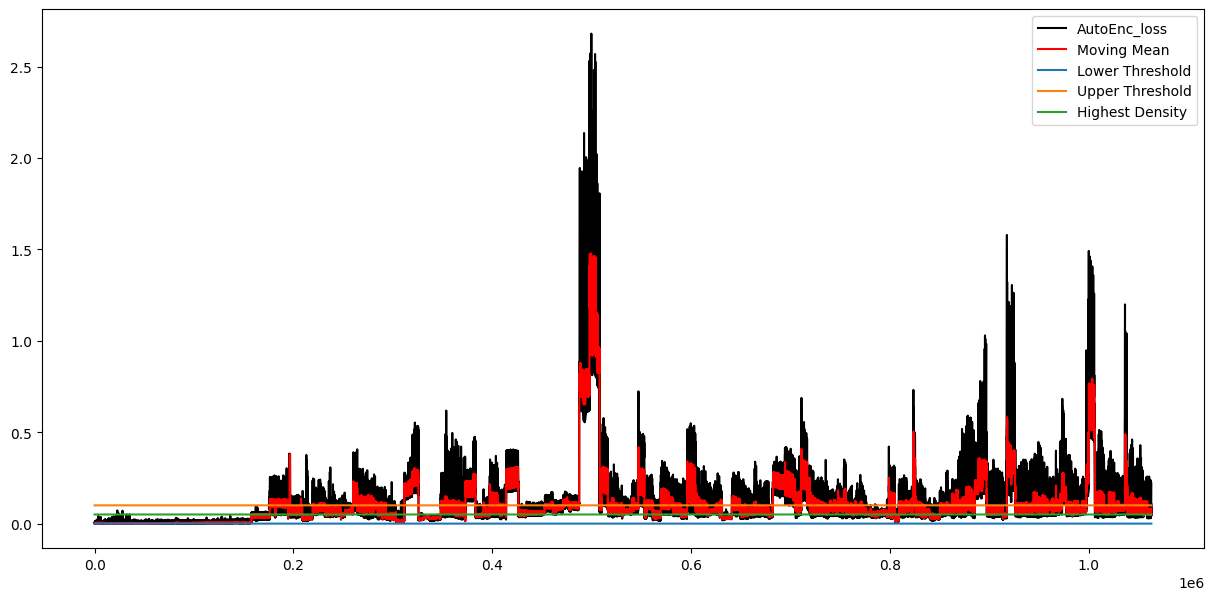

In [68]:
k_anomaly = pd.read_csv('compiled_df//KM_Distance.csv')
score = pd.read_csv('compiled_df//SVM_Score.csv')
enc_loss = pd.read_csv('compiled_df//AutoEncoder_loss.csv')

corr = pd.DataFrame()
corr['SVM_score'] = score['score']
corr['KM_cluster_distance'] = k_anomaly['0']
corr['AutoEnc_loss'] = enc_loss['Loss_mae']



#Creating an array for the thresholds to be plotted over the entire dataset
lower_threshold = np.full((corr['SVM_score'].size, 1), 0)
upper_threshold = np.full((corr['SVM_score'].size, 1), 18000)
high_density_threshold = np.full((corr['SVM_score'].size, 1), 13250)

plt.subplots(figsize=(15,7))

plt.plot(corr.index, corr['SVM_score'], 'k', markersize=1, label = 'OCSVM_score')
#Moving mean plot
plt.plot(corr.index, corr['SVM_score'].rolling(100).mean(), 'r', markersize=1, label = 'Moving Mean')
#Threshold plots
plt.plot(corr.index, lower_threshold, label='Lower Threshold')
plt.plot(corr.index, upper_threshold, label = 'Upper Threshold')
plt.plot(corr.index, high_density_threshold, label = 'Highest Density')
plt.legend(loc='upper right')
plt.show()


lower_threshold = np.full((corr['KM_cluster_distance'].size, 1), 1.2)
upper_threshold = np.full((corr['KM_cluster_distance'].size, 1), 17.5)
high_density_threshold = np.full((corr['KM_cluster_distance'].size, 1), 2.5)

plt.subplots(figsize=(15,7))
  
plt.plot(corr.index, corr['KM_cluster_distance'], 'k', markersize=1, label = 'KM_cluster_distance')
plt.plot(corr.index, corr['KM_cluster_distance'].rolling(100).mean(), 'r', markersize=1, label = 'Moving Mean')
plt.plot(corr.index, lower_threshold, label='Lower Threshold')
plt.plot(corr.index, upper_threshold, label = 'Upper Threshold')
plt.plot(corr.index, high_density_threshold, label = 'Highest Density')
plt.legend(loc='upper right')
plt.show()



lower_threshold = np.full((corr['AutoEnc_loss'].size, 1), 0)
upper_threshold = np.full((corr['AutoEnc_loss'].size, 1), 0.1)
high_density_threshold = np.full((corr['AutoEnc_loss'].size, 1), 0.05)

plt.subplots(figsize=(15,7))
  
plt.plot(corr.index, corr['AutoEnc_loss'], 'k', markersize=1, label = 'AutoEnc_loss')
plt.plot(corr.index, corr['AutoEnc_loss'].rolling(100).mean(), 'r', markersize=1, label = 'Moving Mean')
plt.plot(corr.index, lower_threshold, label='Lower Threshold')
plt.plot(corr.index, upper_threshold, label = 'Upper Threshold')
plt.plot(corr.index, high_density_threshold, label = 'Highest Density')
plt.legend(loc='upper right')
plt.show()


**做散点图对比分析各算法图**

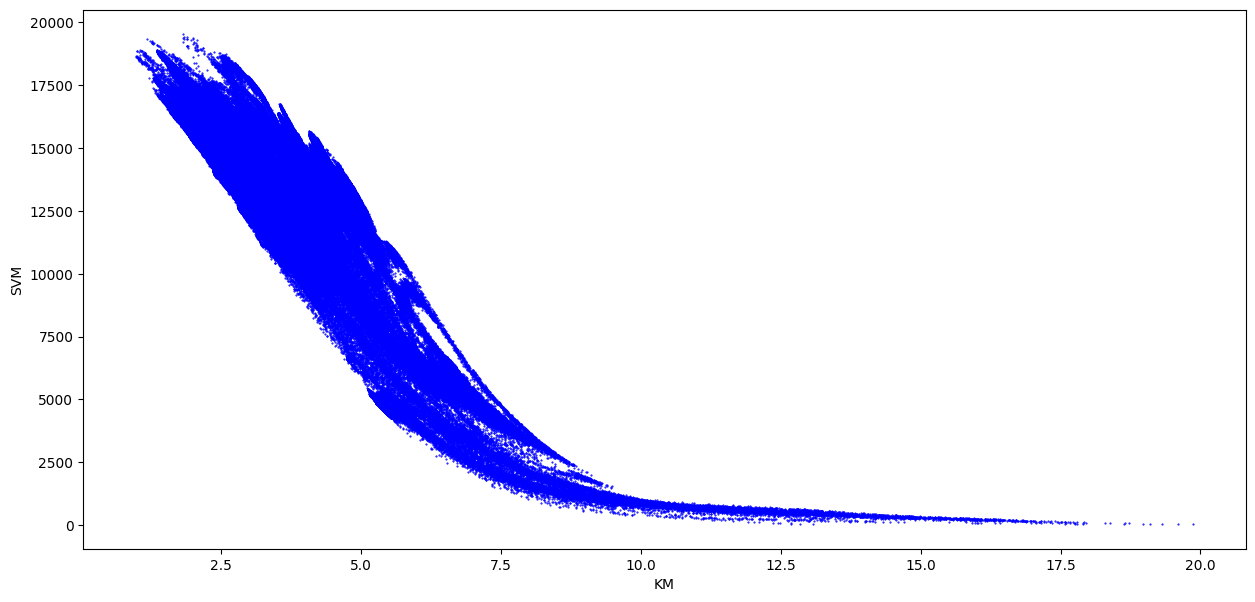

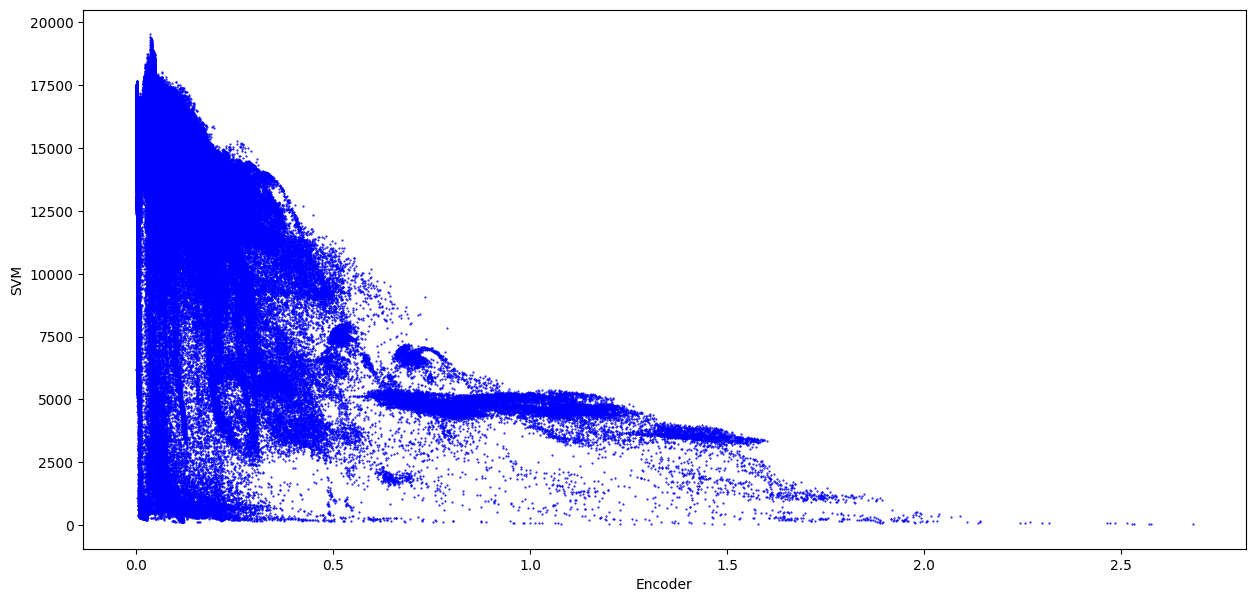

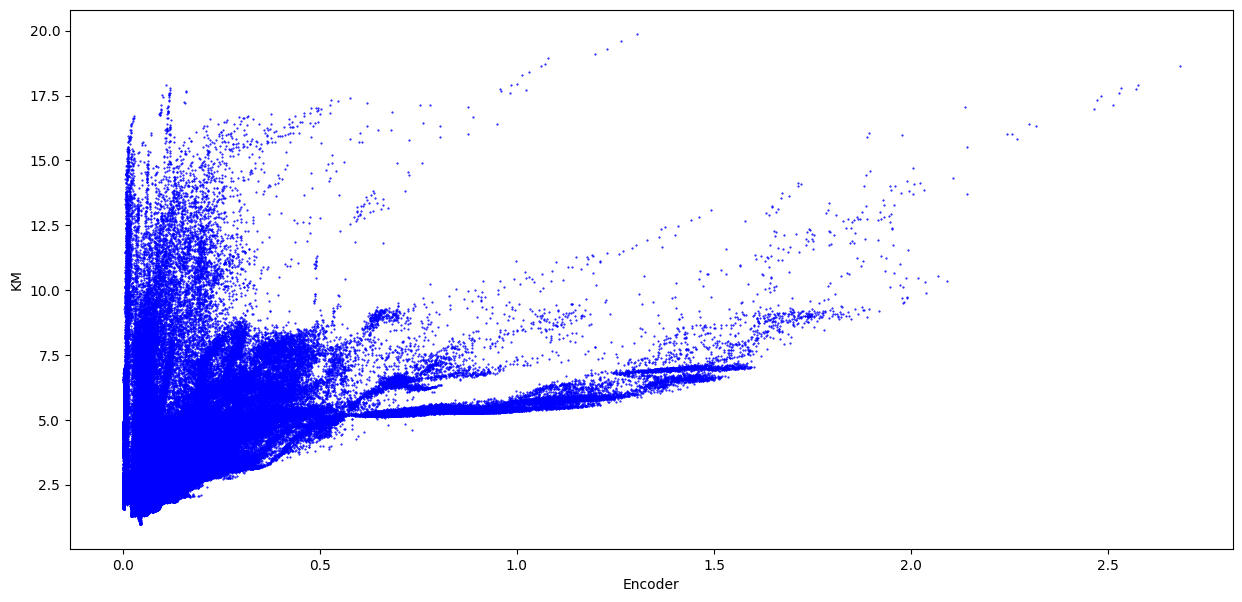

In [69]:
k_anomaly = pd.read_csv('compiled_df//KM_Distance.csv')
score = pd.read_csv('compiled_df//SVM_Score.csv')
enc_loss = pd.read_csv('compiled_df//AutoEncoder_loss.csv')

corr = pd.DataFrame()
corr['SVM_score'] = score['score']
corr['KM_cluster_distance'] = k_anomaly['0']
corr['AutoEnc_loss'] = enc_loss['Loss_mae']




plt.subplots(figsize=(15,7))
  
plt.plot(corr['KM_cluster_distance'],corr['SVM_score'],'b.',markersize=1 )
plt.xlabel('KM')
plt.ylabel('SVM')
plt.show()


plt.subplots(figsize=(15,7))
  
plt.plot(corr['AutoEnc_loss'],corr['SVM_score'],'b.' ,markersize=1 )
plt.xlabel('Encoder')
plt.ylabel('SVM')
plt.show()

plt.subplots(figsize=(15,7))
  
plt.plot(corr['AutoEnc_loss'],corr['KM_cluster_distance'],'b.' ,markersize=1 )
plt.xlabel('Encoder')
plt.ylabel('KM')
plt.show()

# 使用自编码器进行进一步分析

**虽然三种算法在呈现异常值上都具有一定相似性，但是聚类方法混入了很多噪音并且不太能进一步分析。另一方面，自编码器可以获得一个更加确信的结果，虽然我们无法得出结论说一定是在经过损失函数的峰值时组件发生了严重退化，但是相对而言自编码器的结果会更加可信且精确。**

**进一步地，我们会使用确定的阈值来逐月对损失进行分析。**

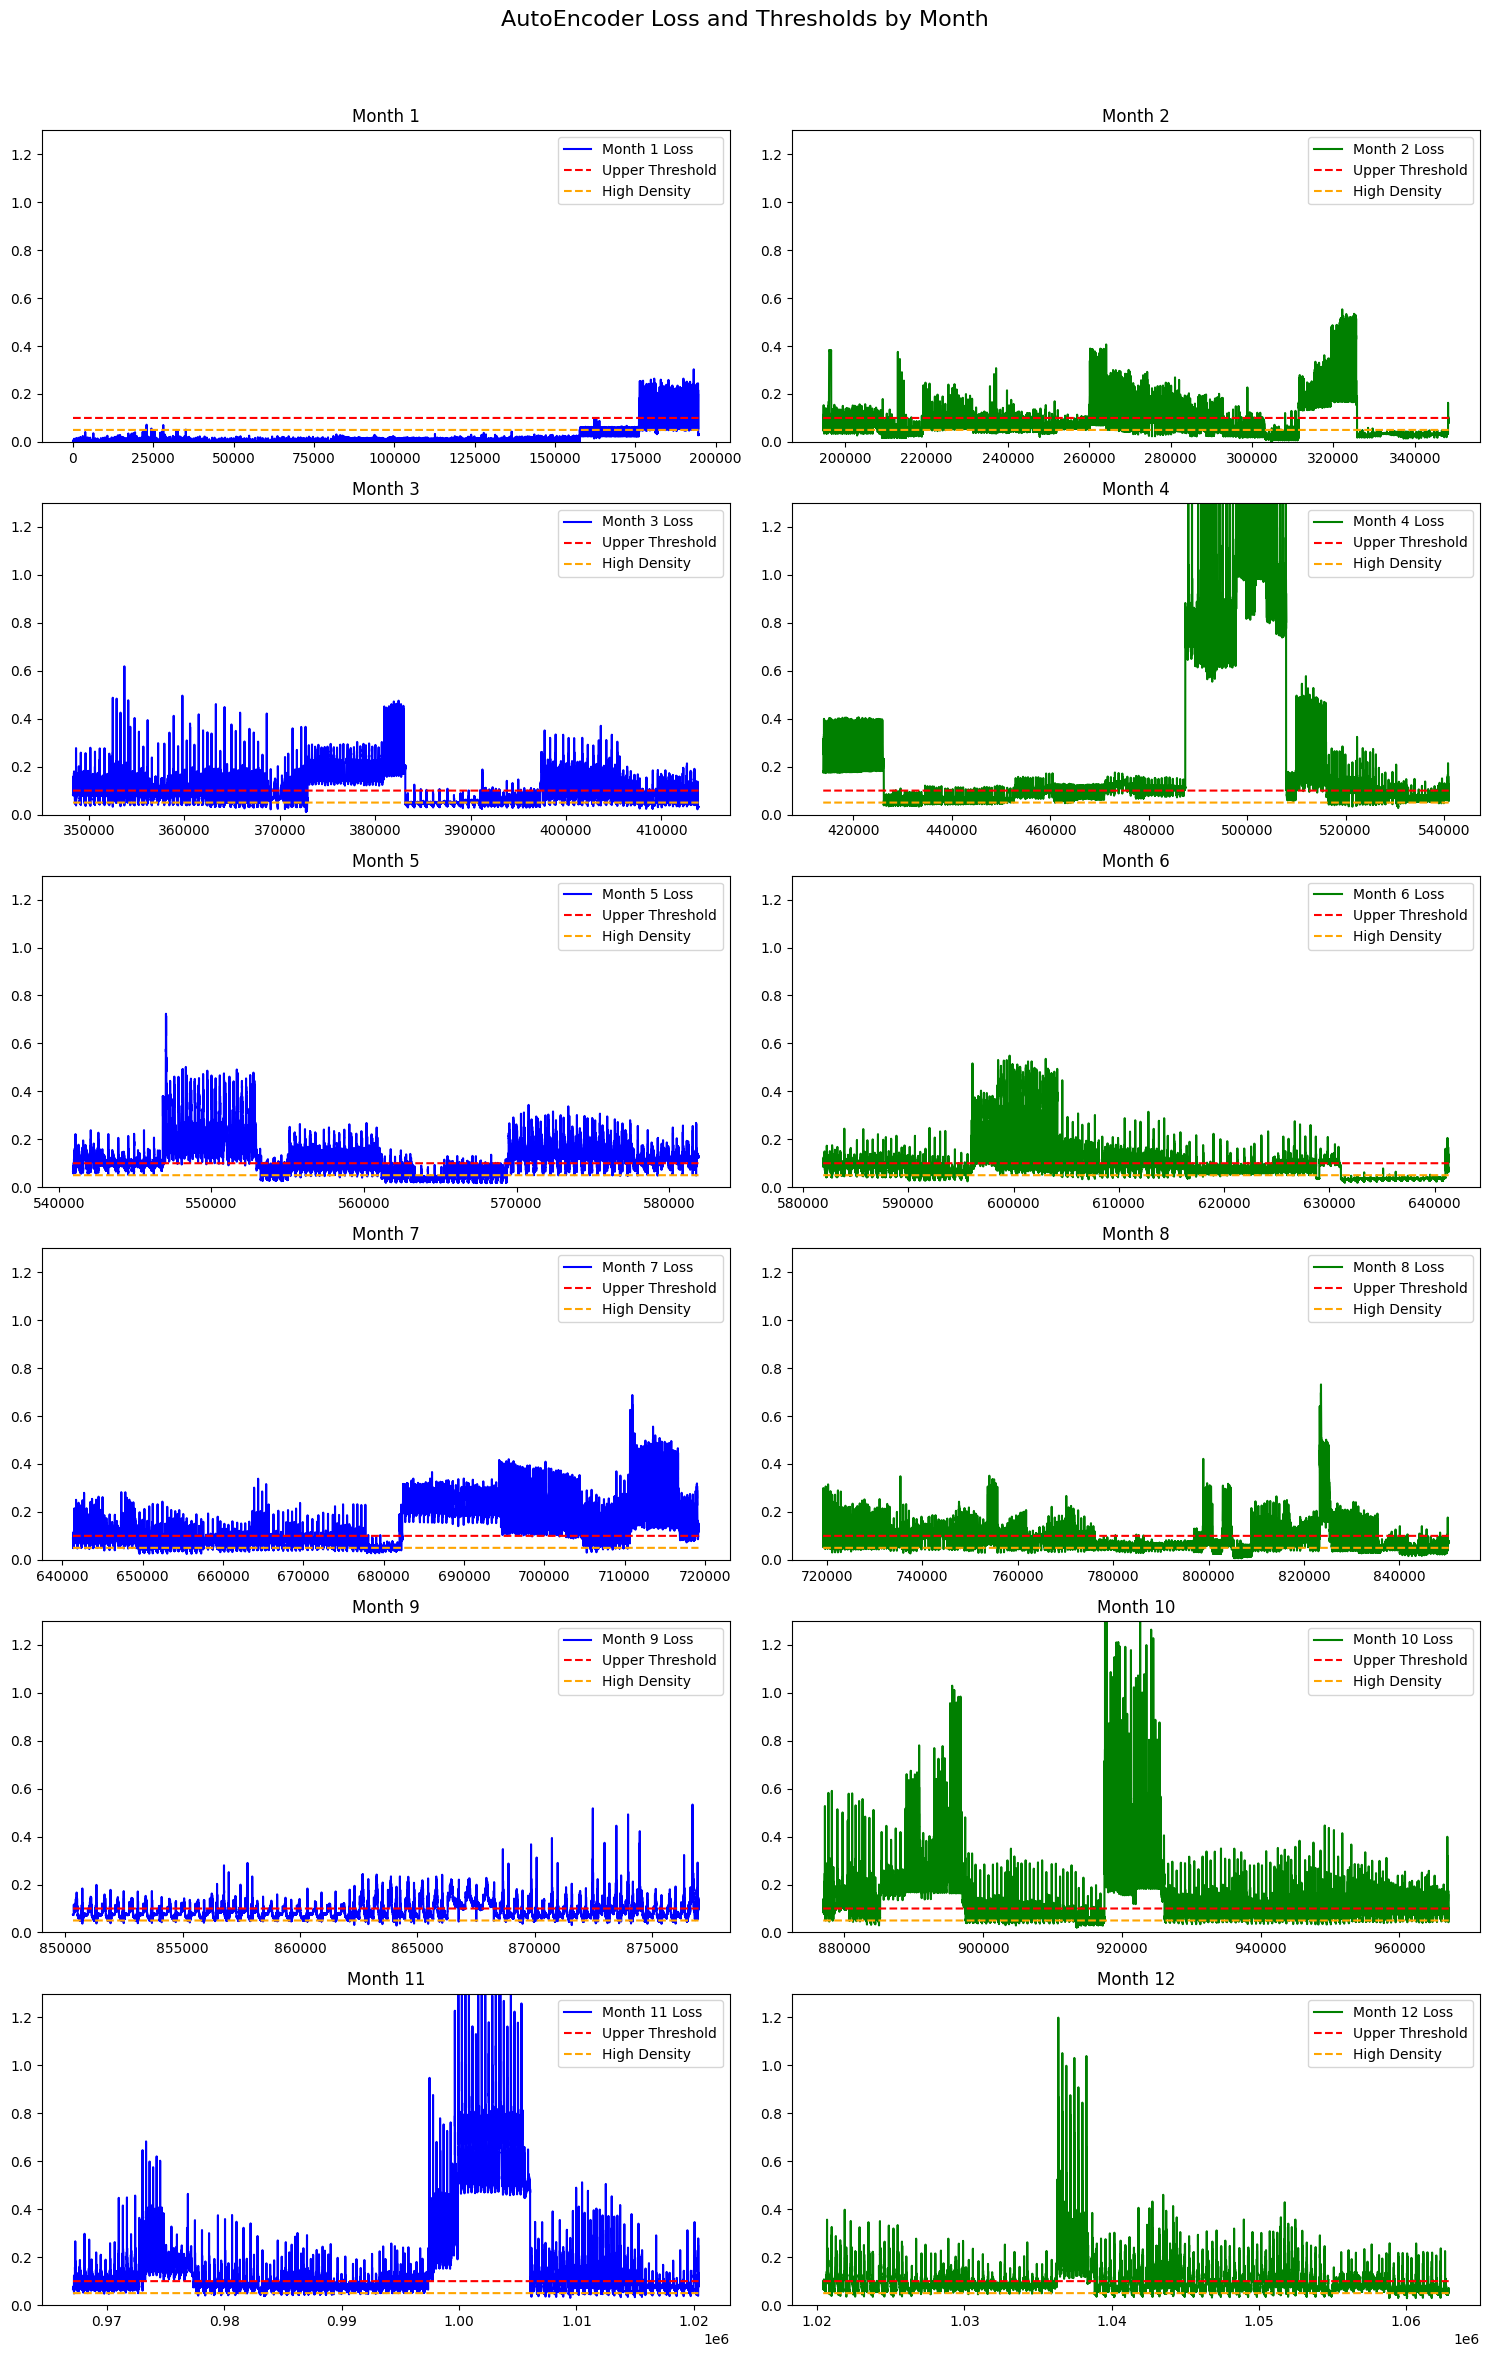

In [2]:
k_anomaly = pd.read_csv('compiled_df//KM_Distance.csv')
score = pd.read_csv('compiled_df//SVM_Score.csv')
enc_loss = pd.read_csv('compiled_df//AutoEncoder_loss.csv')

corr = pd.DataFrame()
corr['SVM_score'] = score['score']
corr['KM_cluster_distance'] = k_anomaly['0']
corr['AutoEnc_loss'] = enc_loss['Loss_mae']

main_df = pd.read_csv('compiled_df//One_year_compiled.csv')
main_df['AutoEnc_loss'] = corr['AutoEnc_loss']

months = sorted(main_df['month'].dropna().unique())
fig, axes = plt.subplots(6, 2, figsize=(15, 24))  
fig.suptitle("AutoEncoder Loss and Thresholds by Month", fontsize=16)

for i in range(0, len(months), 2):
    month1 = months[i]
    month1_df = main_df[main_df['month'] == month1]
    
    upper_threshold = np.full((month1_df['AutoEnc_loss'].size,), 0.1)
    high_density_threshold = np.full((month1_df['AutoEnc_loss'].size,), 0.05)
    
    row = i // 2
    col = 0
    ax = axes[row, col]
    
    ax.plot(month1_df.index, month1_df['AutoEnc_loss'], label=f'Month {month1} Loss', color='blue')
    ax.plot(month1_df.index, upper_threshold, '--', label='Upper Threshold', color='red')
    ax.plot(month1_df.index, high_density_threshold, '--', label='High Density', color='orange')
    ax.set_ylim(0, 1.3)
    ax.legend(loc='upper right')
    ax.set_title(f'Month {month1}')

    if i + 1 < len(months):
        month2 = months[i + 1]
        month2_df = main_df[main_df['month'] == month2]
        
        upper_threshold = np.full((month2_df['AutoEnc_loss'].size,), 0.1)
        high_density_threshold = np.full((month2_df['AutoEnc_loss'].size,), 0.05)
        
        col = 1
        ax = axes[row, col]
        
        ax.plot(month2_df.index, month2_df['AutoEnc_loss'], label=f'Month {month2} Loss', color='green')
        ax.plot(month2_df.index, upper_threshold, '--', label='Upper Threshold', color='red')
        ax.plot(month2_df.index, high_density_threshold, '--', label='High Density', color='orange')
        ax.set_ylim(0, 1.3)
        ax.legend(loc='upper right')
        ax.set_title(f'Month {month2}')

plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

**现在我们可以观察逐月的损失分布**

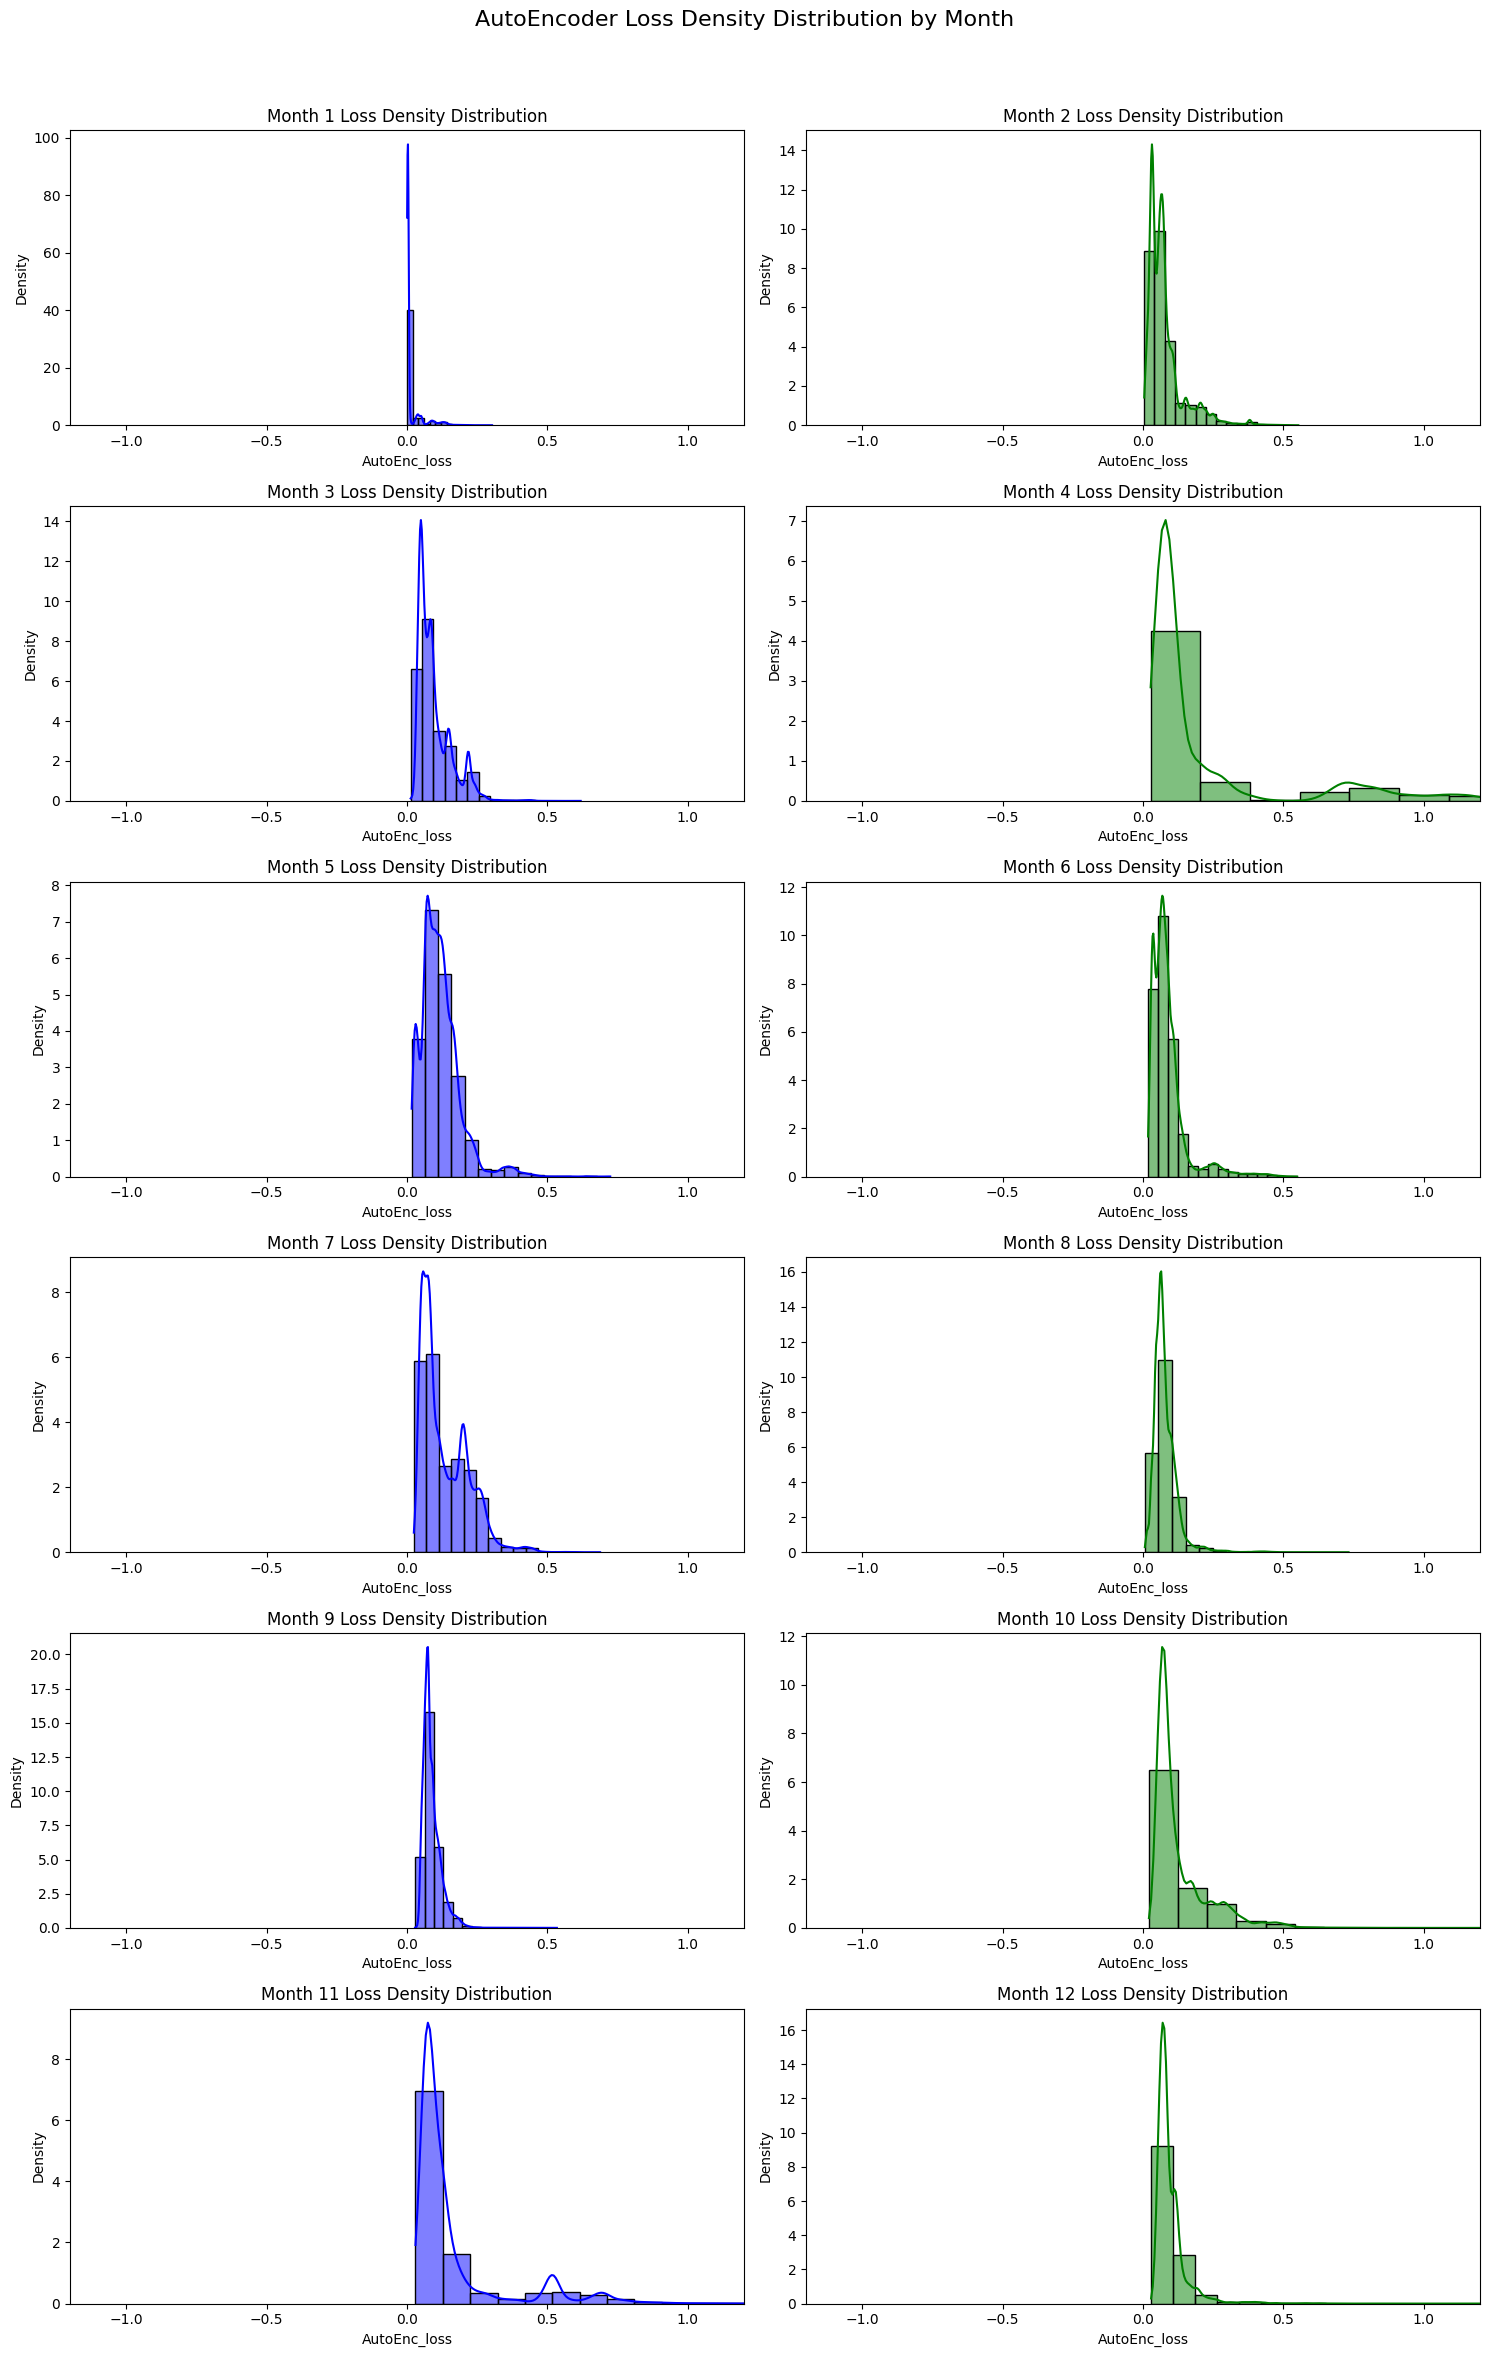

In [6]:
k_anomaly = pd.read_csv('compiled_df//KM_Distance.csv')
score = pd.read_csv('compiled_df//SVM_Score.csv')
enc_loss = pd.read_csv('compiled_df//AutoEncoder_loss.csv')

corr = pd.DataFrame()
corr['SVM_score'] = score['score']
corr['KM_cluster_distance'] = k_anomaly['0']
corr['AutoEnc_loss'] = enc_loss['Loss_mae']

main_df = pd.read_csv('compiled_df//One_year_compiled.csv')
main_df['AutoEnc_loss'] = corr['AutoEnc_loss']

months = sorted(main_df['month'].dropna().unique())


fig, axes = plt.subplots(6, 2, figsize=(15, 24))  
fig.suptitle("AutoEncoder Loss Density Distribution by Month", fontsize=16)

for i, month in enumerate(months):
    month_df = main_df[main_df['month'] == month]
    
    row = i // 2
    col = i % 2

    color = 'blue' if col == 0 else 'green'
    
    sns.histplot(month_df['AutoEnc_loss'], bins=15, kde=True, stat="density", ax=axes[row, col], color=color)
    axes[row, col].set_title(f'Month {month} Loss Density Distribution')
    
    axes[row, col].set_xlim([-1.2, 1.2])

plt.tight_layout(rect=[0, 0, 1, 0.96])  
plt.show()

**一种观察异常的有趣方法是查看分布的尾部。正如我们在按月绘制的图中所见，第 4 个月的异常点数最多。这对损失分布也产生了影响。也许通过查看每个月的峰度，我们可以获得更多信息。**

**峰度可以告诉我们分布的形状。高峰度意味着许多数据点具有相同的值，且尾部或标准差非常小甚至不存在（在我们的例子中，许多数据点接近 0 表示机器状态良好）。低峰度则意味着数据点分布较为分散，分布呈现宽而厚的尾部，几乎与峰值的高度相当。**

Month 1 kurtosis = 7.906415050653691
Month 2 kurtosis = 6.944443632765946
Month 3 kurtosis = 3.1239212609694276
Month 4 kurtosis = 4.176122385058278
Month 5 kurtosis = 5.597273685204533
Month 6 kurtosis = 9.771367616187888
Month 7 kurtosis = 1.043567411601987
Month 8 kurtosis = 22.3084811950491
Month 9 kurtosis = 10.35787238777426
Month 10 kurtosis = 8.127122677145332
Month 11 kurtosis = 5.115334478107439
Month 12 kurtosis = 36.59929239876477


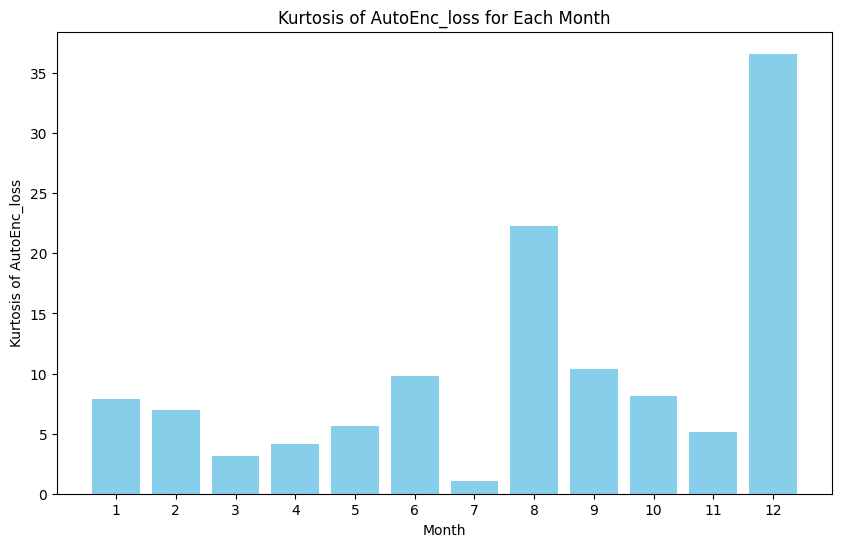

In [17]:
k_anomaly = pd.read_csv('compiled_df//KM_Distance.csv')
score = pd.read_csv('compiled_df//SVM_Score.csv')
enc_loss = pd.read_csv('compiled_df//AutoEncoder_loss.csv')

corr = pd.DataFrame()
corr['SVM_score'] = score['score']
corr['KM_cluster_distance'] = k_anomaly['0']
corr['AutoEnc_loss'] = enc_loss['Loss_mae']

main_df = pd.read_csv('compiled_df//One_year_compiled.csv')
main_df['AutoEnc_loss'] = corr['AutoEnc_loss']

months = sorted(main_df['month'].dropna().unique())

kurtosis_values = []

for month in months:
    month_df = main_df[main_df['month'] == month]
    if not month_df['AutoEnc_loss'].isna().all():
        kurt = month_df['AutoEnc_loss'].dropna().kurtosis()
        kurtosis_values.append(kurt)
        print(f'Month {month} kurtosis = {kurt}')
    else:
        kurtosis_values.append(float('nan'))

plt.figure(figsize=(10, 6))
plt.bar(months, kurtosis_values, color='skyblue')
plt.xlabel('Month')
plt.ylabel('Kurtosis of AutoEnc_loss')
plt.title('Kurtosis of AutoEnc_loss for Each Month')
plt.xticks(months)
plt.show()

**因此，峰度较低的月份是异常较多的月份，这可以在一定程度上反映机器的状态。**


# 组件分析

**现在我们已经知道机器出现问题的时间点，我们将尝试找出是哪个组件或传感器导致了自编码器中的这一异常。为此，我们将再次训练自编码器，并获取每一列的预测值和损失，以查看哪一列对总损失的贡献最大。**

In [16]:
main_df = pd.read_csv('compiled_df//One_year_compiled.csv')
main_df = main_df.drop(['day', 'hour', 'sample_Number', 'month', 'timestamp'], axis=1)
main_df = handle_non_numeric(main_df)
X = main_df

scaler = preprocessing.MinMaxScaler()

X = pd.DataFrame(scaler.fit_transform(X), 
                              columns=X.columns, 
                              index=X.index)



X = preprocessing.scale(X)


train_percentage = 0.15
train_size = int(len(main_df.index)*train_percentage)

X_train = X[:train_size]

seed(10)
set_random_seed(10)
act_func = 'elu'

# Input layer:
model=Sequential()
# First hidden layer, connected to input vector X. 
model.add(Dense(50,activation=act_func,
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_shape=(X_train.shape[1],)
               )
         )

model.add(Dense(10,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(50,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(X_train.shape[1],
                kernel_initializer='glorot_uniform'))

model.compile(loss='mse',optimizer='adam')

NUM_EPOCHS=50
BATCH_SIZE=200

history=model.fit(np.array(X_train),np.array(X_train),
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.1,
                  verbose = 1)

Train on 143492 samples, validate on 15944 samples
Epoch 1/50
143492/143492 [==============================] - 2s 11us/sample - loss: 0.0926 - val_loss: 0.0127
Epoch 2/50
143492/143492 [==============================] - 1s 10us/sample - loss: 0.0026 - val_loss: 0.0083
Epoch 3/50
143492/143492 [==============================] - 1s 10us/sample - loss: 0.0011 - val_loss: 0.0071
Epoch 4/50
143492/143492 [==============================] - 1s 10us/sample - loss: 6.5741e-04 - val_loss: 0.0061
Epoch 5/50
143492/143492 [==============================] - 1s 10us/sample - loss: 4.5191e-04 - val_loss: 0.0058
Epoch 6/50
143492/143492 [==============================] - 1s 10us/sample - loss: 3.4047e-04 - val_loss: 0.0050
Epoch 7/50
143492/143492 [==============================] - 1s 10us/sample - loss: 2.6378e-04 - val_loss: 0.0049
Epoch 8/50
143492/143492 [==============================] - 1s 10us/sample - loss: 2.1054e-04 - val_loss: 0.0041
Epoch 9/50
143492/143492 [==============================]

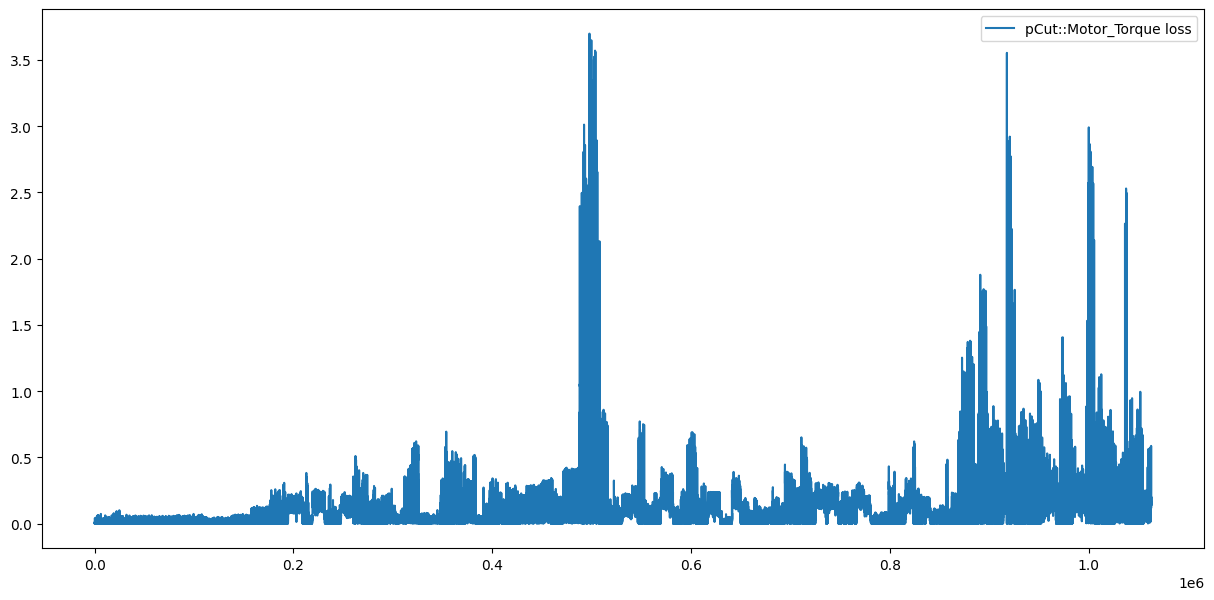

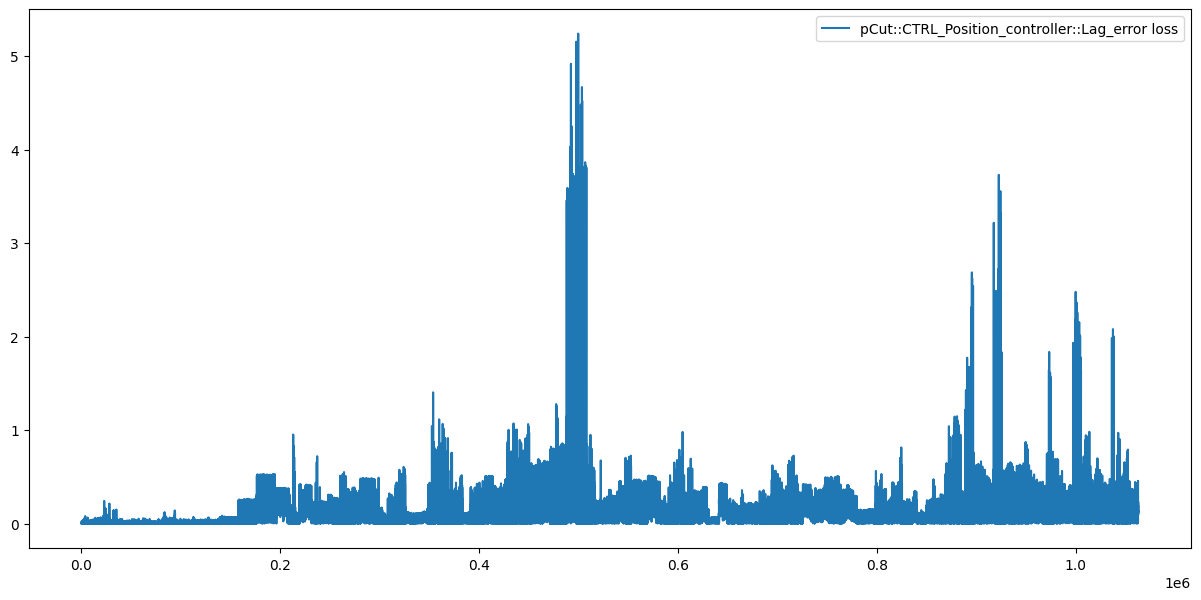

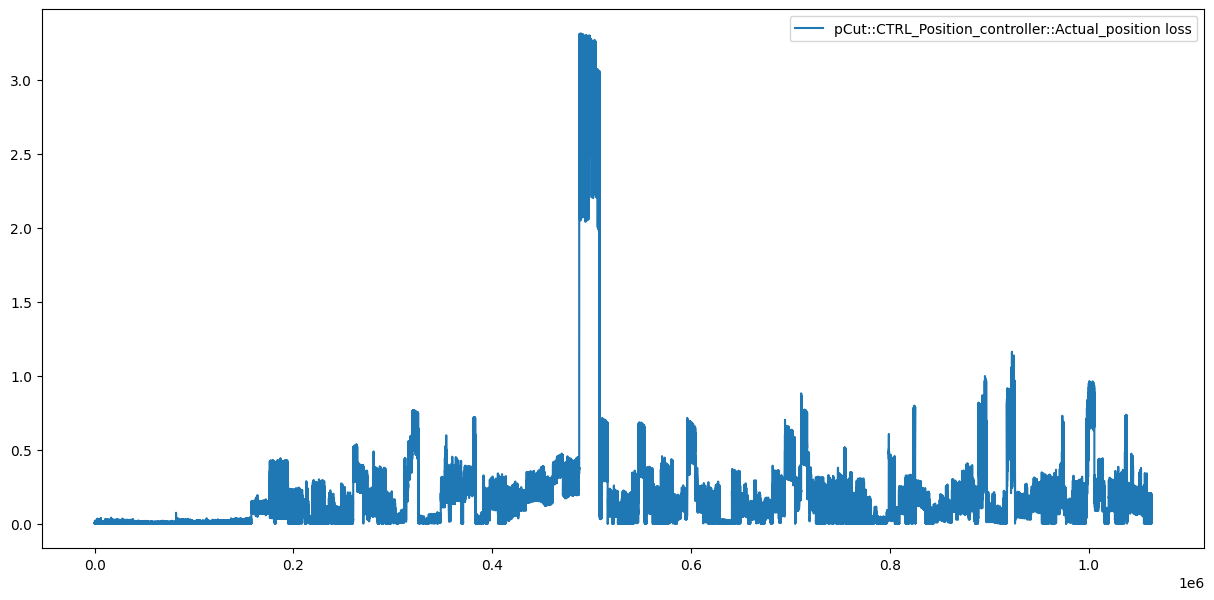

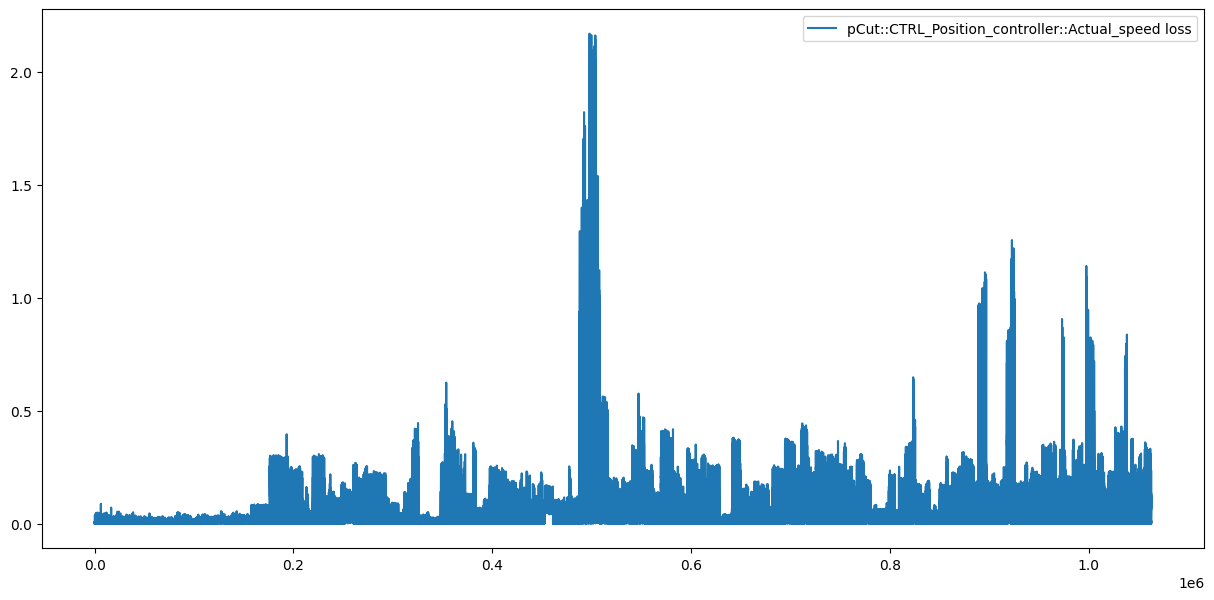

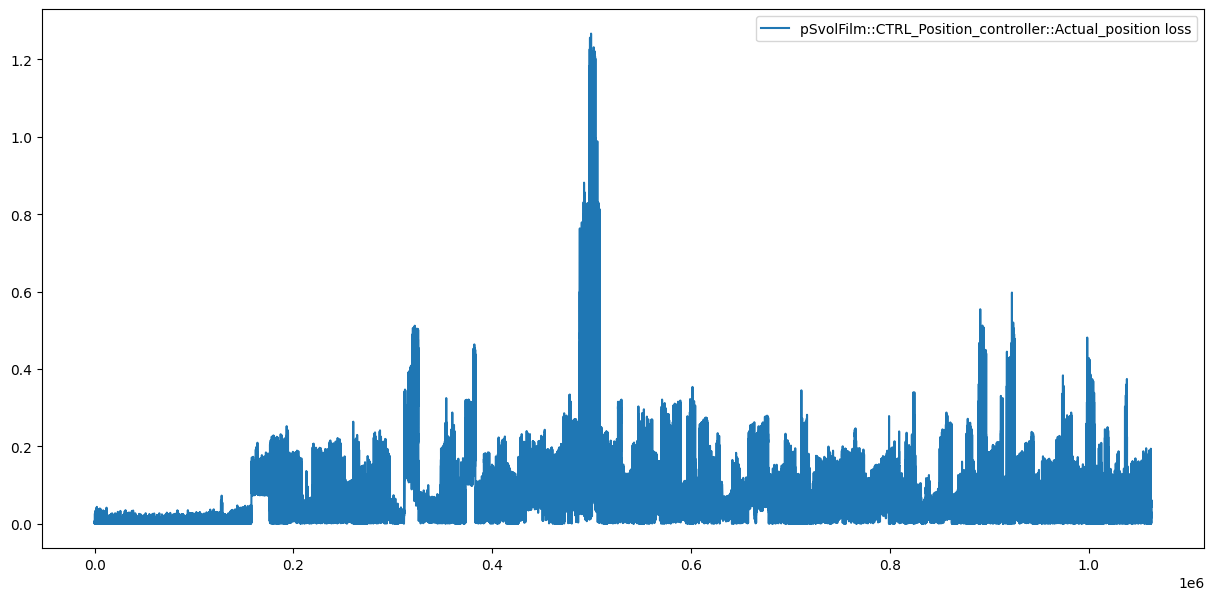

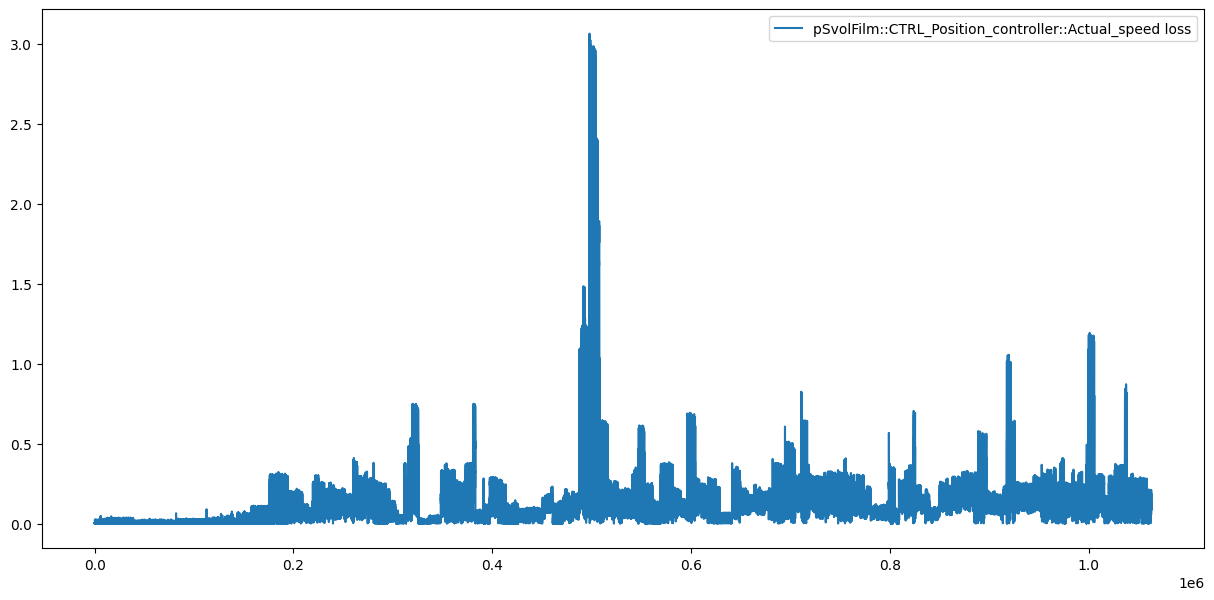

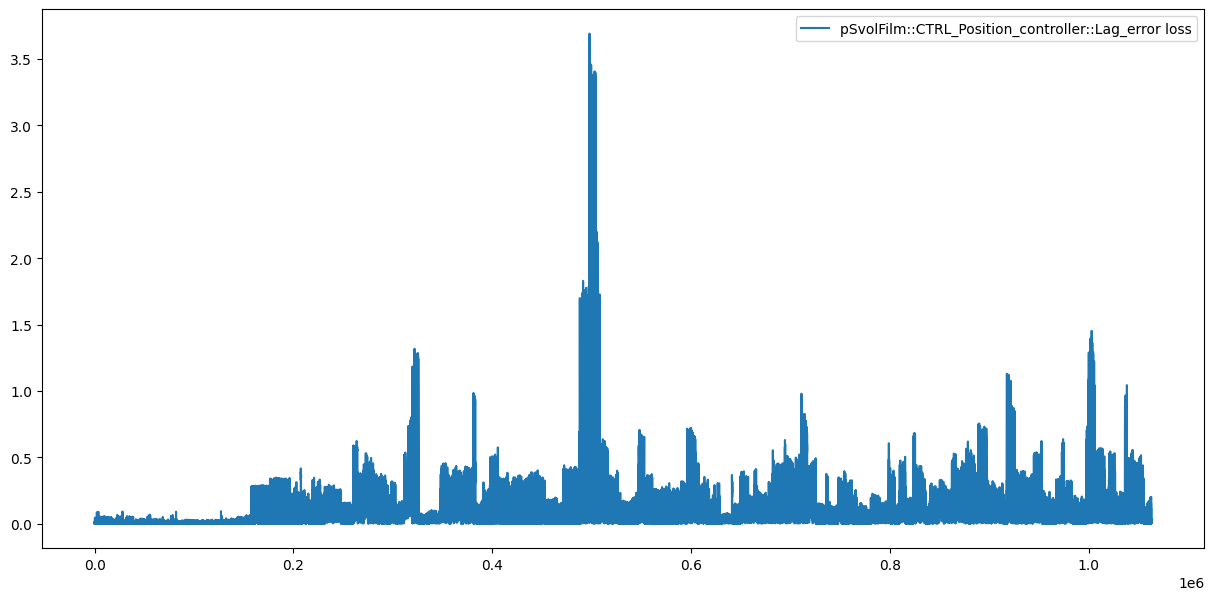

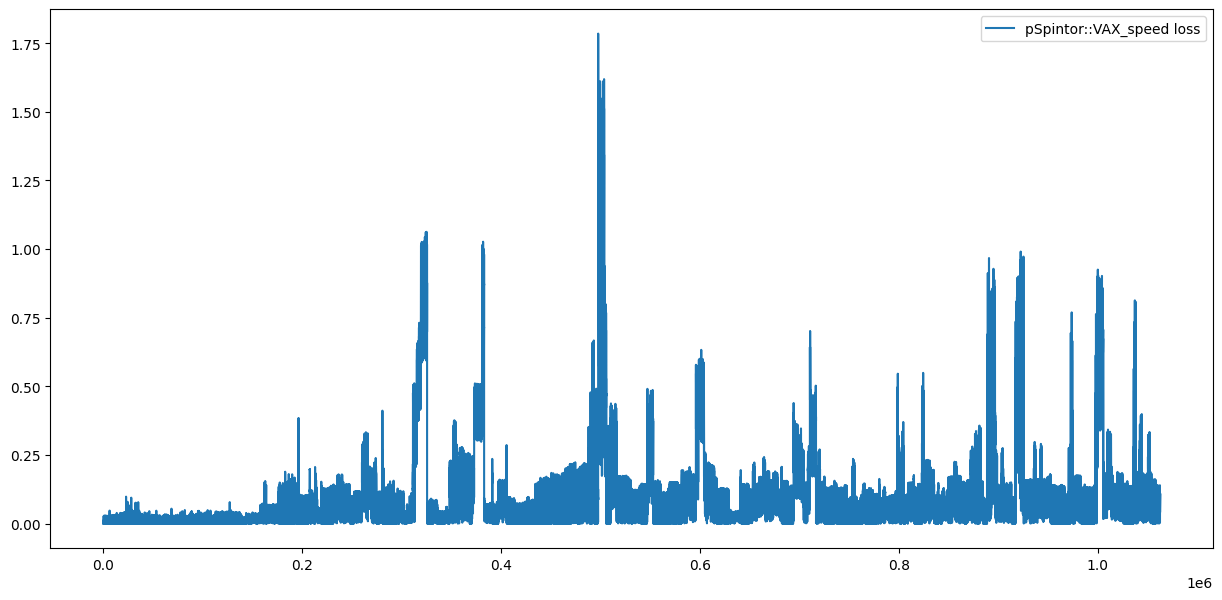

In [17]:
#Predicting and passing prediction to dataframe
X_pred = model.predict(np.array(X))
X_pred = pd.DataFrame(X_pred,columns=main_df.columns)
X_pred.index = pd.DataFrame(main_df).index

X = pd.DataFrame(X,columns=main_df.columns)
X.index = pd.DataFrame(main_df).index

loss_df = pd.DataFrame()

#Dropping mode as it can't logically contribute to degredation
main_df.drop('mode',axis=1, inplace=True)

for column in main_df.columns:
    loss_df[f'{column}'] = (X_pred[f'{column}'] - X[f'{column}']).abs()
     
    plt.subplots(figsize=(15,7))
    plt.plot(loss_df.index, loss_df[f'{column}'], label=f'{column} loss')
    plt.legend(loc='upper right')
    
    plt.show()
    
loss_df.to_csv('compiled_df//AutoEncoder_loss_p_column.csv')

**现在我们将对每一行应用 Softmax 函数，以获得每一列对总损失的贡献百分比。这样，每一行的总和将为 1。**

In [18]:
sftmax_df = pd.read_csv('compiled_df//AutoEncoder_loss_p_column.csv', index_col=0)
sftmax_df = softmax(sftmax_df, axis=1)
sftmax_df.describe()

pCut::Motor_Torque  pCut::CTRL_Position_controller::Lag_error  \
count        1.062912e+06                               1.062912e+06   
mean         1.229433e-01                               1.241099e-01   
std          1.365739e-02                               1.570225e-02   
min          1.243941e-02                               1.283401e-02   
25%          1.194543e-01                               1.212781e-01   
50%          1.247748e-01                               1.250943e-01   
75%          1.290829e-01                               1.296117e-01   
max          4.816700e-01                               7.385587e-01   

       pCut::CTRL_Position_controller::Actual_position  \
count                                     1.062912e+06   
mean                                      1.384479e-01   
std                                       6.695710e-02   
min                                       2.429140e-02   
25%                                       1.222492e-01   
50%                                       1.251137e-01   
75%                                       1.340106e-01   
max                                       7.332611e-01   

       pCut::CTRL_Position_controller::Actual_speed  \
count                                  1.062912e+06   
mean                                   1.181710e-01   
std                                    1.188141e-02   
min                                    1.365211e-02   
25%                                    1.153340e-01   
50%                                    1.194794e-01   
75%                                    1.248269e-01   
max                                    1.928010e-01   

       pSvolFilm::CTRL_Position_controller::Actual_position  \
count                                       1.062912e+06      
mean                                        1.196895e-01      
std                                         1.407611e-02      
min                                         4.465641e-03      
25%                                         1.166594e-01      
50%                                         1.226501e-01      
75%                                         1.255098e-01      
max                                         1.512526e-01      

       pSvolFilm::CTRL_Position_controller::Actual_speed  \
count                                       1.062912e+06   
mean                                        1.271984e-01   
std                                         1.207348e-02   
min                                         5.159445e-03   
25%                                         1.246867e-01   
50%                                         1.268201e-01   
75%                                         1.306411e-01   
max                                         3.283179e-01   

       pSvolFilm::CTRL_Position_controller::Lag_error  pSpintor::VAX_speed  
count                                    1.062912e+06         1.062912e+06  
mean                                     1.254193e-01         1.240208e-01  
std                                      1.489908e-02         1.504728e-02  
min                                      1.040346e-02         5.751858e-03  
25%                                      1.194748e-01         1.209074e-01  
50%                                      1.250079e-01         1.252075e-01  
75%                                      1.312021e-01         1.289430e-01  
max                                      4.949013e-01         2.247366e-01

**绘制每一列对总损失贡献的百分比**

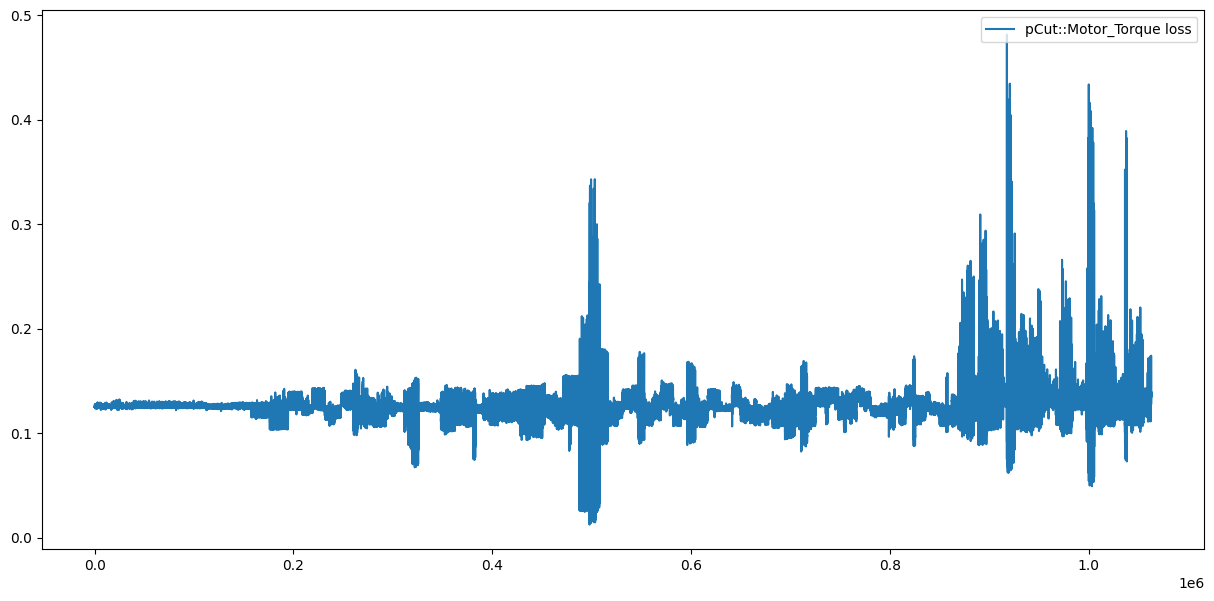

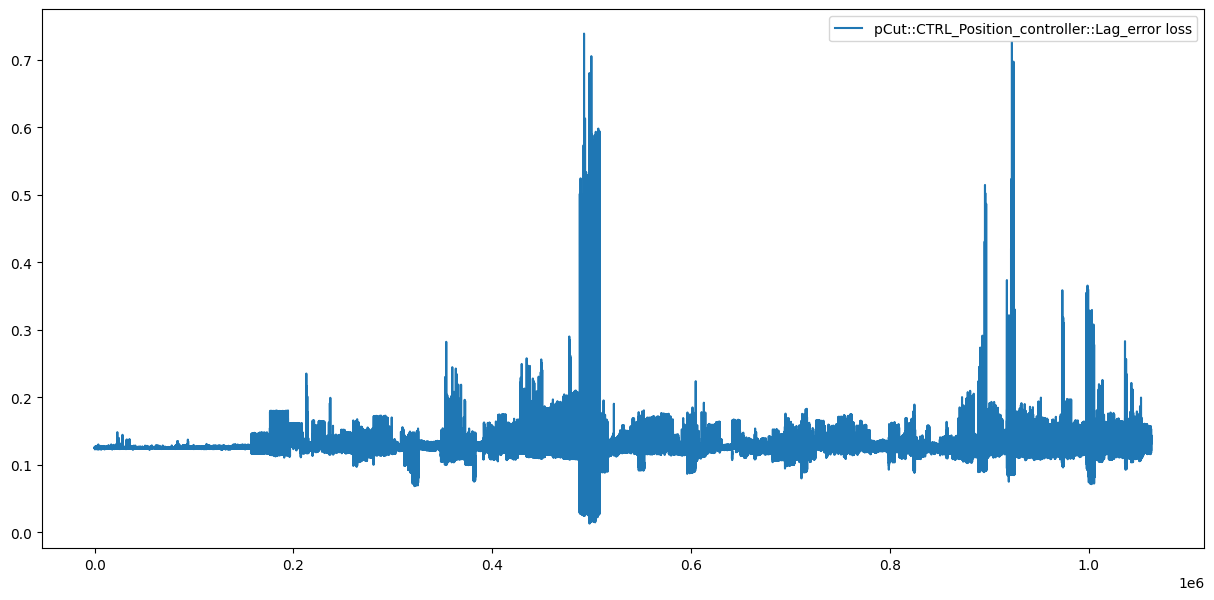

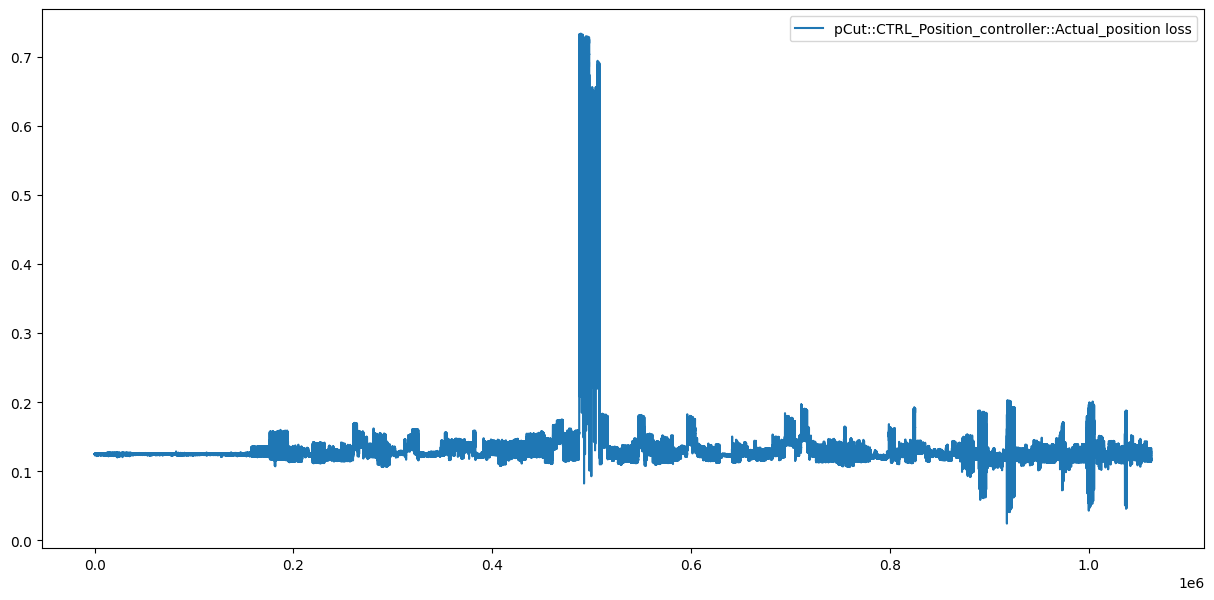

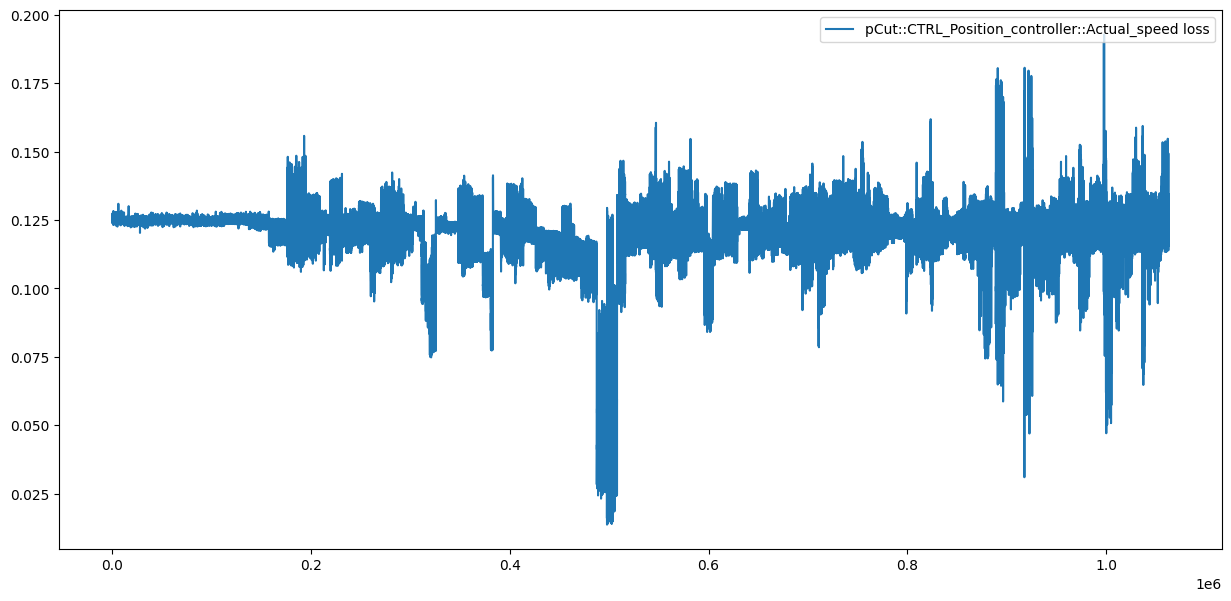

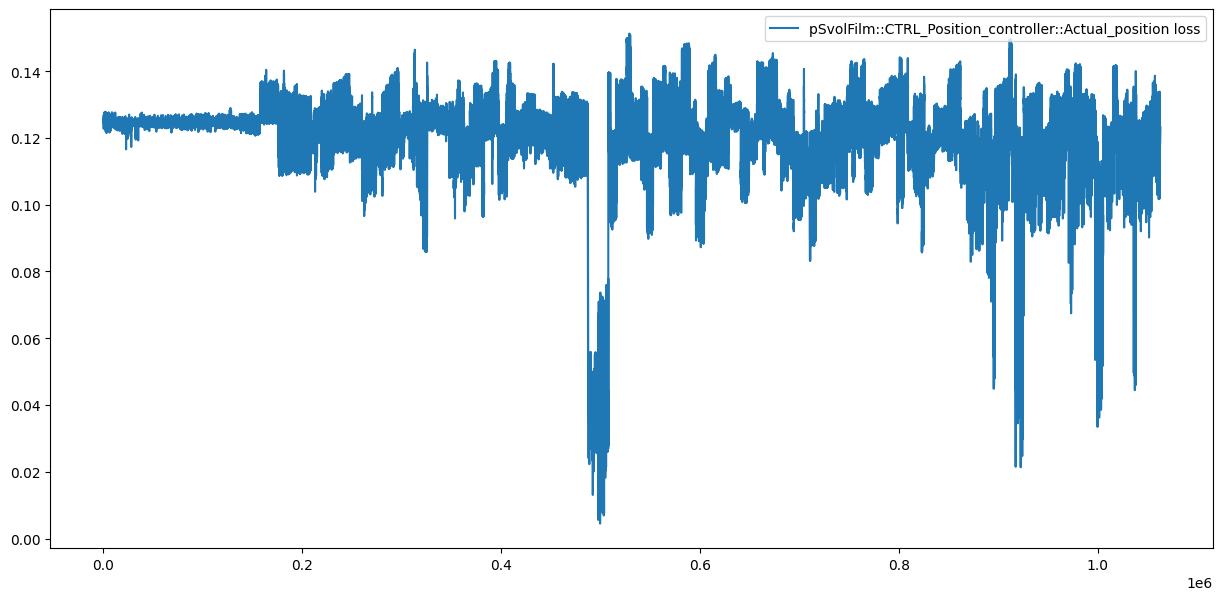

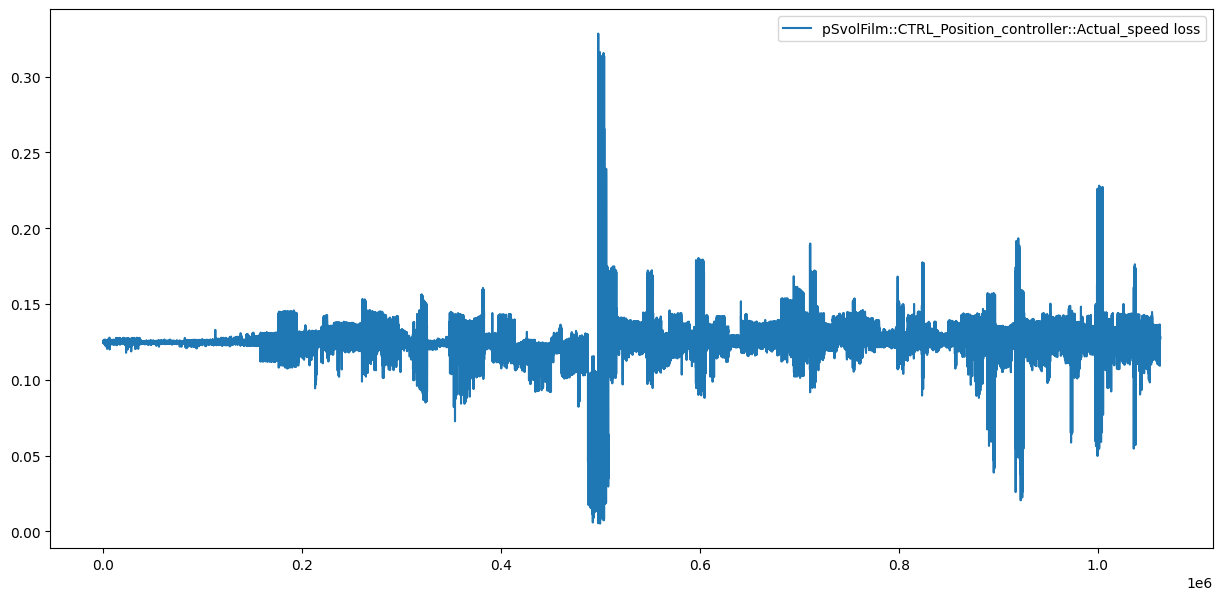

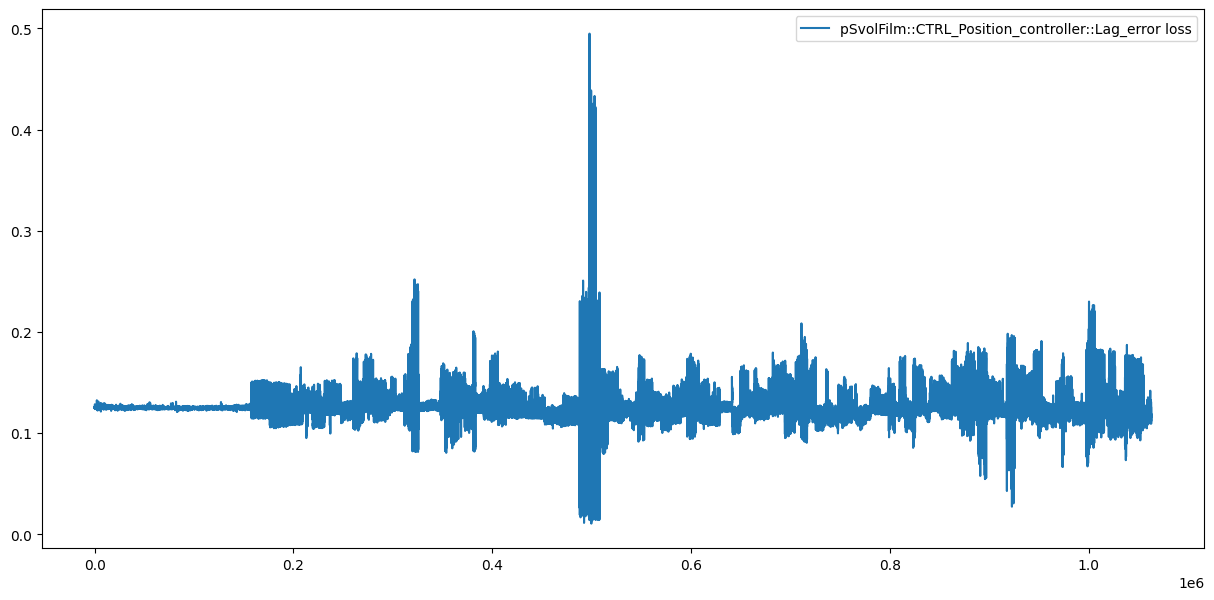

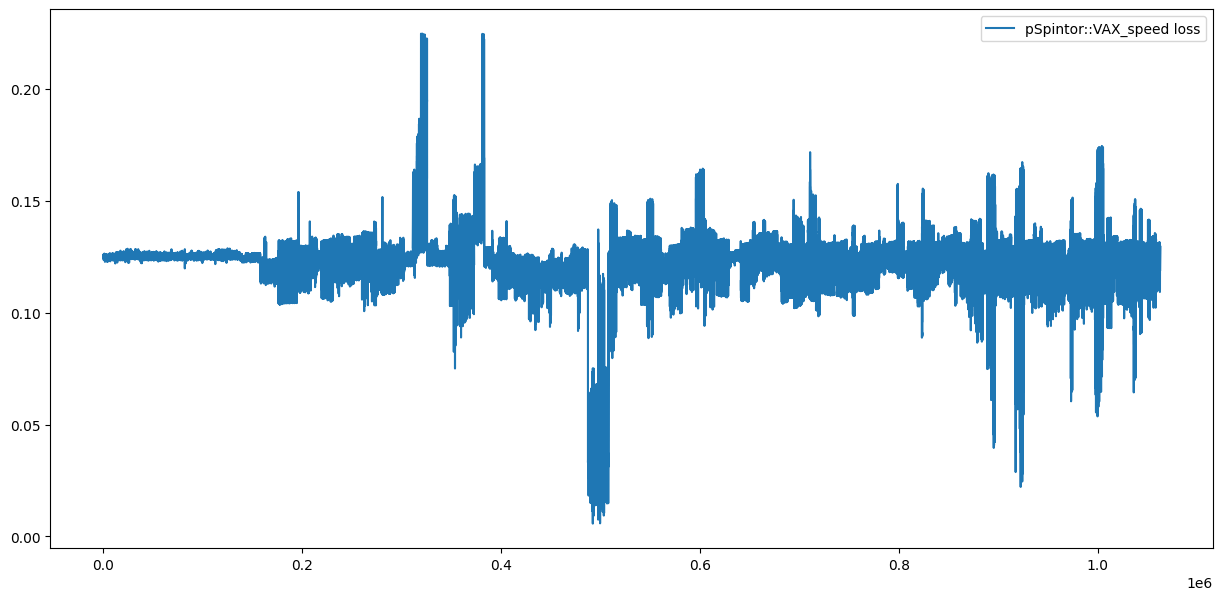

In [19]:
for column in sftmax_df.columns:
    

    plt.subplots(figsize=(15,7))
    plt.plot(sftmax_df.index, sftmax_df[f'{column}'], label=f'{column} loss')
    plt.legend(loc='upper right')
    
    plt.show()

**现在我们可以绘制一个堆叠图，以更好地可视化每一列对总损失的贡献。正如你将看到的，刀片位置在我们观察到的峰值处对总损失的贡献非常大。**

(0.0, 1.0)

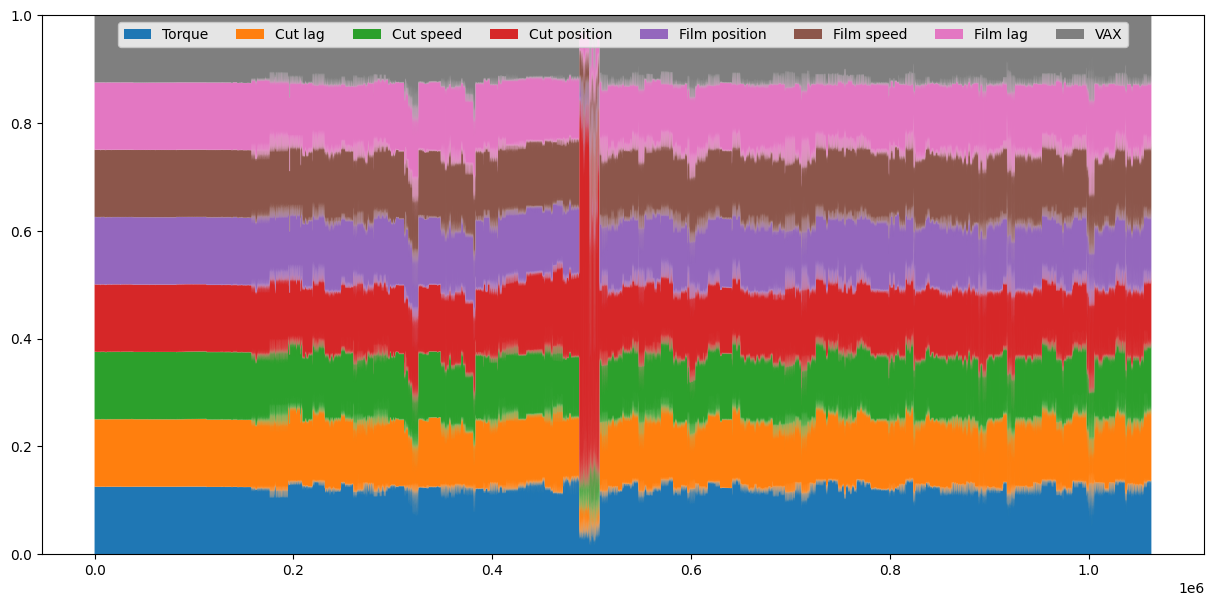

In [20]:
plt.subplots(figsize=(15,7))

df_label = ['Torque', 'Cut lag','Cut speed','Cut position','Film position','Film speed','Film lag','VAX']
plt.stackplot(sftmax_df.index, sftmax_df['pCut::Motor_Torque'],
             sftmax_df['pCut::CTRL_Position_controller::Lag_error'],
             sftmax_df['pCut::CTRL_Position_controller::Actual_speed'],
              sftmax_df['pCut::CTRL_Position_controller::Actual_position'],
             sftmax_df['pSvolFilm::CTRL_Position_controller::Actual_position'],
             sftmax_df['pSvolFilm::CTRL_Position_controller::Actual_speed'],
             sftmax_df['pSvolFilm::CTRL_Position_controller::Lag_error'],
             sftmax_df['pSpintor::VAX_speed'],
             labels = df_label)

plt.legend(loc='upper center', ncol=8)

plt.ylim(0,1)

(0.0, 1.0)

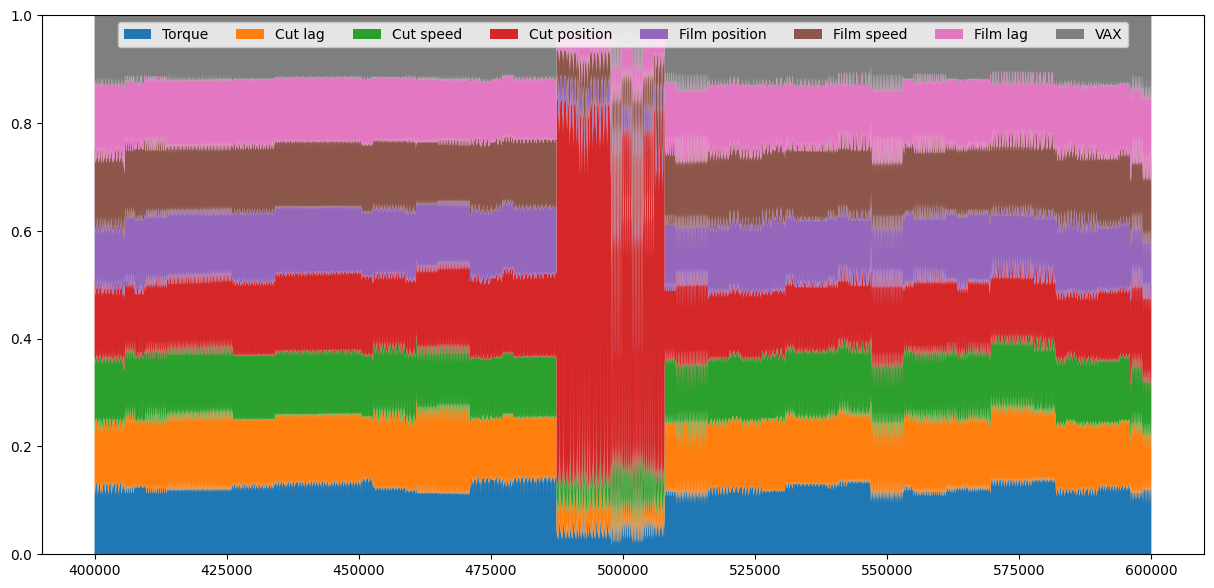

In [21]:
plt.subplots(figsize=(15,7))

df_label = ['Torque', 'Cut lag','Cut speed','Cut position','Film position','Film speed','Film lag','VAX']

sftmax_df = sftmax_df[400000:600000]

plt.stackplot(sftmax_df.index, sftmax_df['pCut::Motor_Torque'],
             sftmax_df['pCut::CTRL_Position_controller::Lag_error'],
             sftmax_df['pCut::CTRL_Position_controller::Actual_speed'],
              sftmax_df['pCut::CTRL_Position_controller::Actual_position'],
             sftmax_df['pSvolFilm::CTRL_Position_controller::Actual_position'],
             sftmax_df['pSvolFilm::CTRL_Position_controller::Actual_speed'],
             sftmax_df['pSvolFilm::CTRL_Position_controller::Lag_error'],
             sftmax_df['pSpintor::VAX_speed'],
             labels = df_label)

plt.legend(loc='upper center', ncol=8)

plt.ylim(0,1)

**刀片的滞后误差也占了总损失的很大一部分。可能的解释是刀片已经磨损，因此在切割薄膜时开始偏离机器为其设定的路径。**

**现在我们将查看每一列对总损失贡献的分布，以更好地了解哪些传感器导致了更高的损失。**

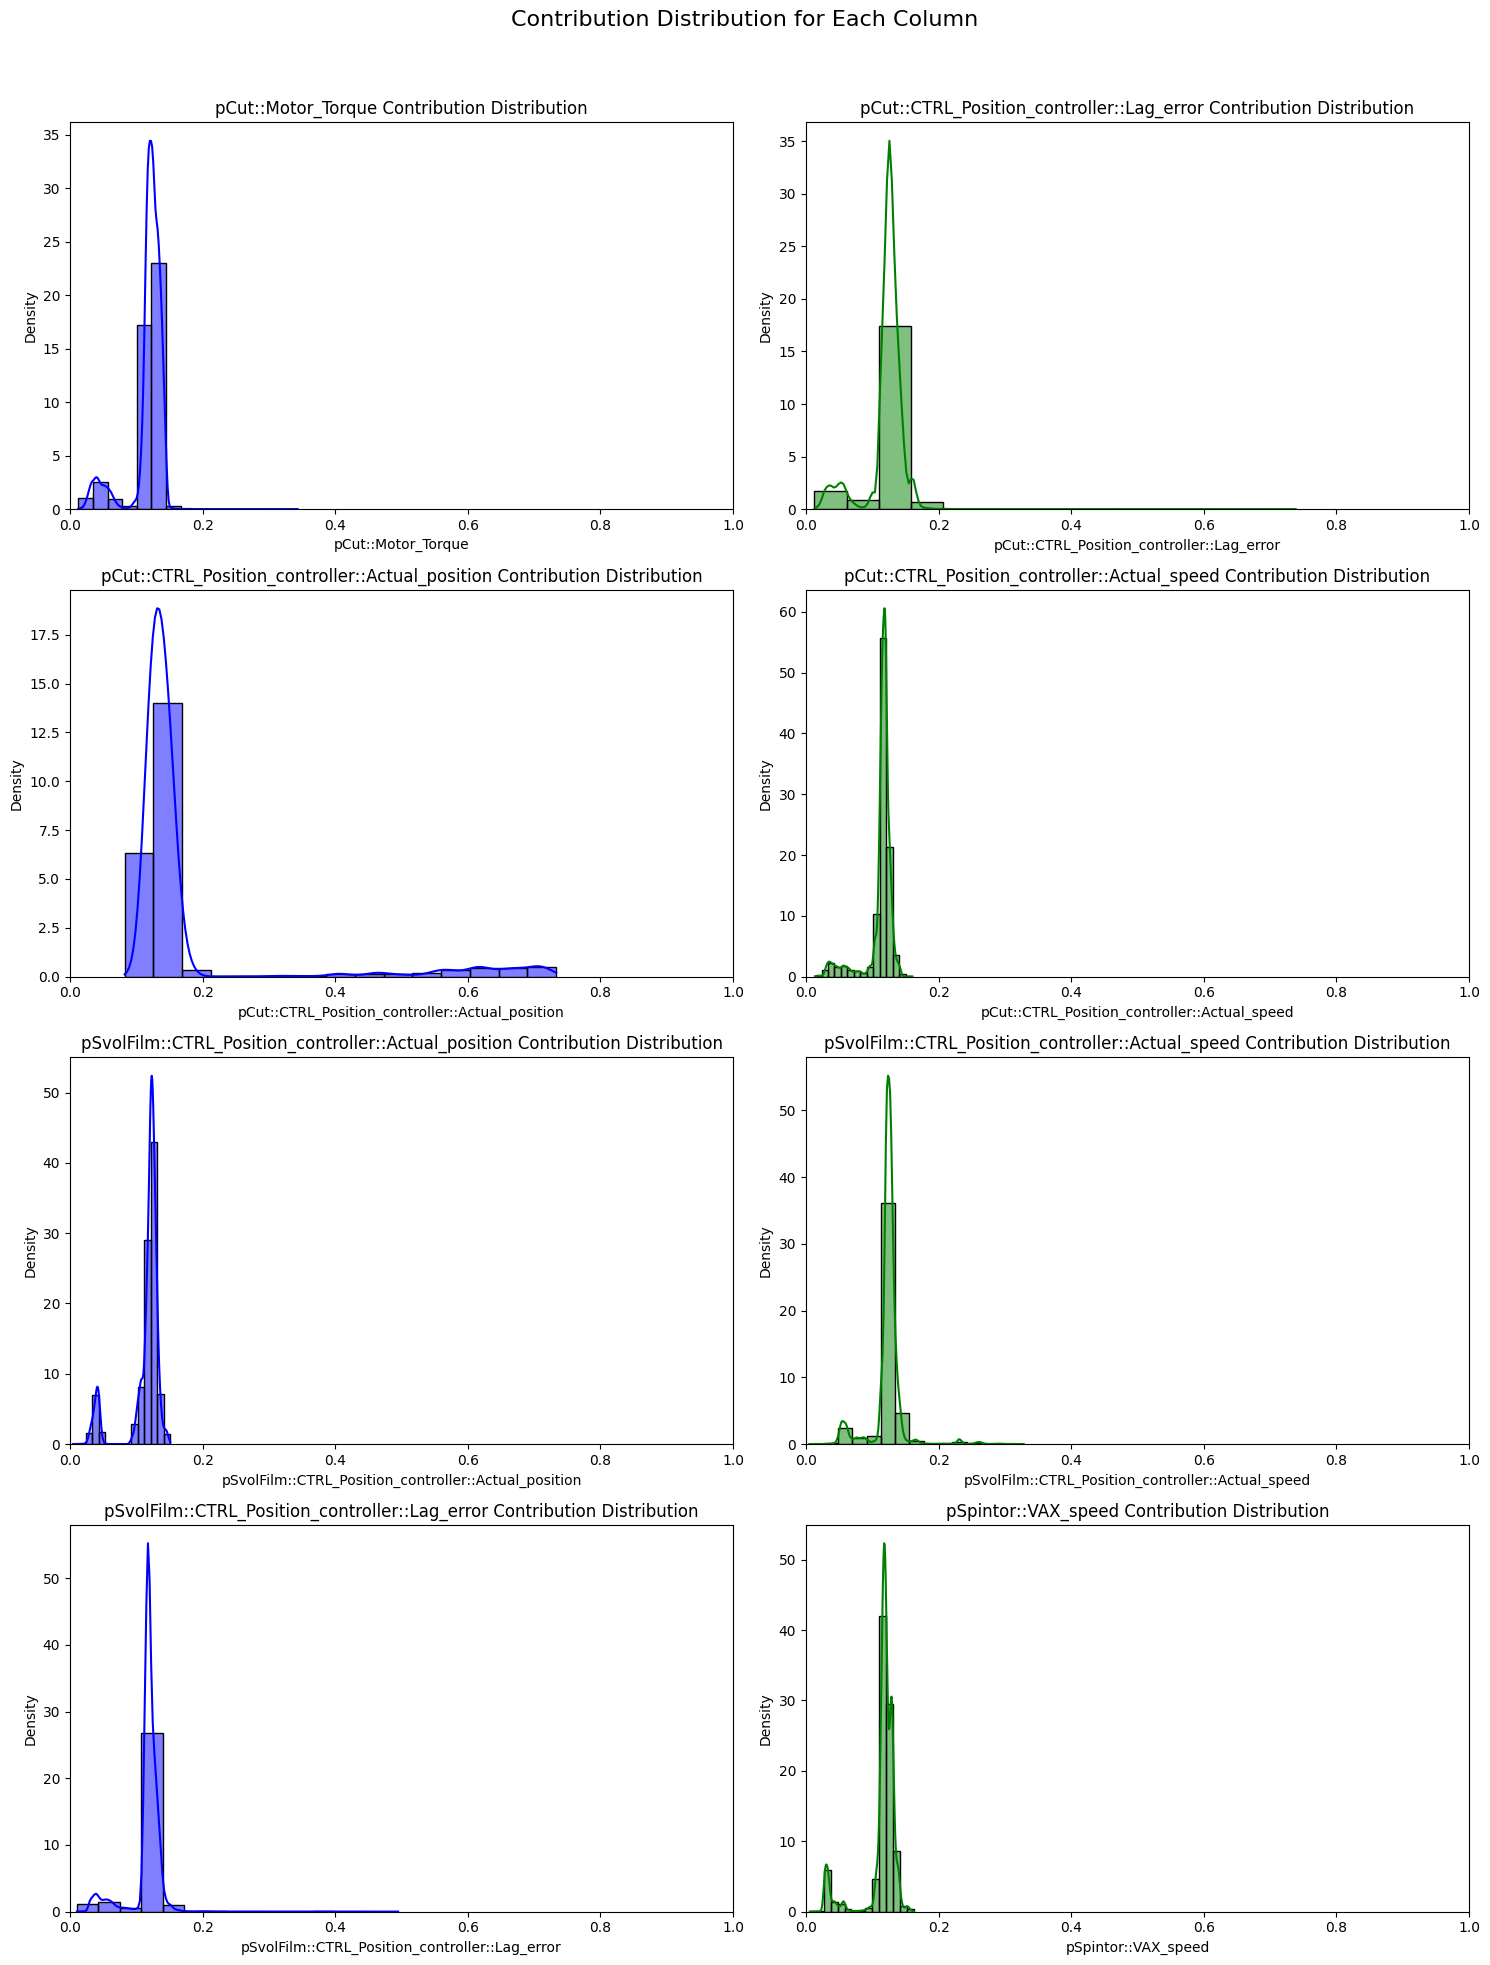

In [24]:
columns = sftmax_df.columns
num_columns = len(columns)

fig, axes = plt.subplots((num_columns + 1) // 2, 2, figsize=(15, 20))  
fig.suptitle("Contribution Distribution for Each Column", fontsize=16)

for i, column in enumerate(columns):
    row = i // 2
    col = i % 2

    color = 'blue' if col == 0 else 'green'
    sns.histplot(sftmax_df[column], bins=15, kde=True, stat="density", ax=axes[row, col], color=color)
    axes[row, col].set_title(f'{column} Contribution Distribution')
    axes[row, col].set_xlim(0, 1)

if num_columns % 2 != 0:
    axes[-1, -1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# 结论 

**通过收集的所有信息，我们可以确定机器发生大规模退化的时间和位置。我们还可以知道全年哪些测量值对损失的贡献更大，这告诉我们这些参数和组件可能需要更多关注。百分位阈值、分布异常分析、支持向量机（SVM）等多种方法都可以用来检测组件的长期磨损情况。**

**这种方法的一个问题是需要对数据进行全面预处理和缩放，然后再传递给算法。解决这个问题的方法是使用该数据集或其一部分，并将其与新的数据片段结合用于系统健康分析。对于每一个需要分析的新数据片段，我们移除之前添加的片段，保持原始数据集不变。**

# 参考

**-- https://www.sciencedirect.com/science/article/pii/S221282711830307X**

**-- https://towardsdatascience.com/machine-learning-for-anomaly-detection-and-condition-monitoring-d4614e7de770**

